## Set-up

In [1]:
# Libraries

import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import collections
import keras 
import multiprocessing
import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
# Limit the GPU usage

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Check what version of CUDA is used

!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


In [4]:
# Check GPU is available

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
# Check GPU name

tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
# Moderate the available GPU memory

!nvidia-smi

Thu Mar 27 23:08:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 571.96                 Driver Version: 571.96         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P8             11W /  200W |   11852MiB /  12282MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load the data set

In [8]:
# Define input dimension

img_width = 512
img_height = 512
img_channels = 3

In [9]:
# Load the training and testing data
# As we are running the program locally, we are only required to copy the path to where our data is stored

train_path = "C:\\Users\\Sven\\Desktop\\EE981project\\Data\\images_roof_centered_geotiff"
path_mask = "C:\\Users\Sven\\Desktop\\EE981project\Data\\masks_segments_reviewed"
path_mask_seg = "C:\\Users\\Sven\Desktop\\EE981project\\Data\masks_superstructures_reviewed"

train_ids = next(os.walk(train_path))
mask_ids = next(os.walk(path_mask))
mask_seg_ids = next(os.walk(path_mask_seg))

print(len(train_ids[2]), len(mask_ids[2]), len(mask_seg_ids[2]))

1880 1880 1880


In [10]:
# Create empty tensors which will be populated by pixel values

X_full = np.zeros((len(train_ids[2]), img_height, img_width, img_channels), dtype = np.uint8)
Y_full = np.zeros((len(mask_ids[2]), img_height, img_width,1), dtype = np.bool_)

# X_full and Y_full are the whole data set

In [11]:
# Populate the two training tensors (one containing images and one containing masks)

for n, id in tqdm(enumerate(train_ids[2]), total = len(train_ids[2])):
    path = train_path + "\\" + id
    img = imread(path)[:,:,:img_channels]
    X_full[n] = img
    mask = imread(path_mask + "\\" + id.strip('.tif')+".png")
    mask = (mask != 17) # 17 is background

    Y_full[n] = tf.reshape(mask, [img_height, img_width,1])

## Note that you might need to change "\\" to "/" if not running locally

100%|██████████| 1880/1880 [00:04<00:00, 376.12it/s]


In [12]:
# Split the data into training, validation and test set

X_train_with_val, X_test, Y_train_with_val, Y_test = train_test_split(X_full, Y_full, test_size=0.10, random_state=52, shuffle=True)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_with_val, Y_train_with_val, test_size=1/9, random_state=52, shuffle=True)

In [13]:
# Check the size of the created sets

print(len(X_train), len(X_val), len(X_test), len(X_train_with_val))

1504 188 188 1692


## Display few observations

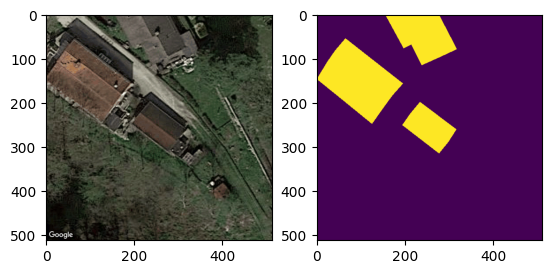

In [14]:
i = 0

plt.subplot(1, 2, 1)
plt.imshow(X_full[i])

plt.subplot(1, 2, 2)
plt.imshow(Y_full[i])

## Create a second Mask data set which excludes segments

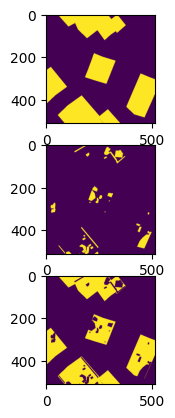

In [15]:
# The process of creating a new mask for a single image

# Rooftop
plt.subplot(3, 1, 1)
a = imread("C:\\Users\\Sven\\Desktop\\EE981project\\Data\\masks_segments_reviewed\\2.png")
a = (a != 17)
plt.imshow(a)

# Rooftop segments
plt.subplot(3, 1, 2)
b = imread("C:\\Users\\Sven\\Desktop\\EE981project\\Data\\masks_superstructures_reviewed\\2.png")
b = (b != 8) 
plt.imshow(b)

# Rooftop without segments
plt.subplot(3, 1, 3)
c = ((a == True) & (b == False))
plt.imshow(c)

In [16]:
# Create an empy tensor

Y_seg_full = np.zeros((len(mask_ids[2]), img_height, img_width,1), dtype = np.bool_)

In [17]:
# Populate the tensor

for n, id in tqdm(enumerate(train_ids[2]), total = len(train_ids[2])):

    mask = imread(path_mask + "\\" + id.strip('.tif')+".png")
    mask_seg = imread(path_mask_seg + "\\" + id.strip('.tif')+".png")

    mask = (mask != 17) # Label rooftop as True
    mask_seg = (mask_seg != 8) # Label superstructures as True

    mask = tf.reshape(mask, [img_height, img_width,1])
    mask_seg = tf.reshape(mask_seg, [img_height, img_width,1])
    
    Y_seg_full[n] = ((mask == True) & (mask_seg == False))

100%|██████████| 1880/1880 [00:05<00:00, 329.39it/s]


In [18]:
Y_seg_full.shape

(1880, 512, 512, 1)

In [19]:
# Split the data into training, validation and test set
# Having the same seed as in the first split should ensure that the same indices are used

Y_train_with_val_seg, Y_test_seg = train_test_split(Y_seg_full, test_size=0.1, random_state=52, shuffle=True)

Y_train_seg, Y_val_seg = train_test_split(Y_train_with_val_seg, test_size=1/9, random_state=52, shuffle=True)

In [20]:
# Check the size of created sets

print(len(Y_train_seg),len(Y_val_seg),len(Y_test_seg),len(Y_train_with_val_seg))

1504 188 188 1692


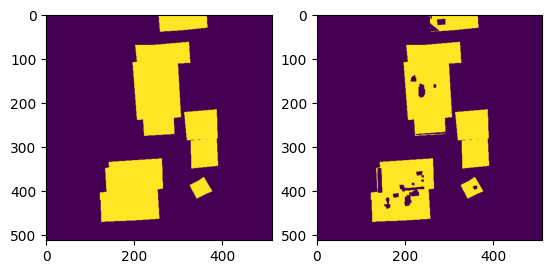

In [21]:
# Check the data was correctly divided

plt.subplot(1, 2, 1)
plt.imshow(Y_train[95])

plt.subplot(1, 2, 2)
plt.imshow(Y_train_seg[95])

## Perform geometric data augmentation

### Visualise the transformations that are considered

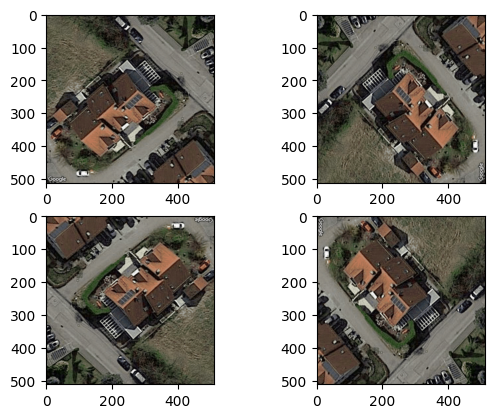

In [22]:
# Rotating an image

plt.subplot(2, 2, 1)
plt.imshow(X_train[519])

# Rotate the original image 90 degress
rot1 = tf.image.rot90(X_train[519])  
plt.subplot(2, 2, 2)
plt.imshow(rot1)

# Rotate the original image 180 degress
rot2 = tf.image.rot90(rot1)
plt.subplot(2, 2, 3)
plt.imshow(rot2)

# Rotate the original image 270 degress
rot3 = tf.image.rot90(rot2)
plt.subplot(2, 2, 4)
plt.imshow(rot3)

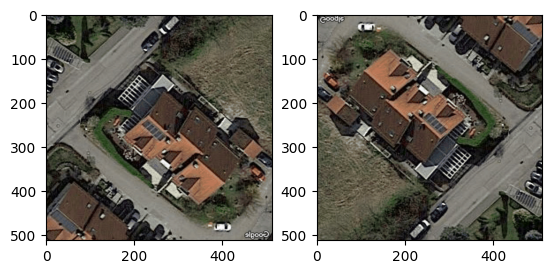

In [23]:
# Flip around the y-axis

plt.subplot(1, 2, 1)
plt.imshow(tf.image.flip_left_right(X_train[519]))

plt.subplot(1, 2, 2)
plt.imshow(tf.image.flip_up_down(X_train[519]))

### Create an augmented data set with these transformations

This augmented data set was initialy created with the idea of using it to train a more robust model. However, the obtained data set was too large for our hardware. If running the code with bigger GPU, we suggest using this augmented data set.

In [ ]:
# Create empty tensors which will be populated by pixel values

# X_train_augmented = np.zeros((len(train_ids[2])*6, img_height, img_width, img_channels), dtype = np.uint8)
# Y_train_augmented = np.zeros((len(mask_ids[2])*6, img_height, img_width, 1), dtype = np.bool_)
# Y_train_seg_augmented = np.zeros((len(mask_seg_ids[2])*6, img_height, img_width, 1), dtype = np.bool_)

In [ ]:
## Populate the two training tensors (one containing images and one containing masks)

# for n in range(len(X_train)):

#     # Store the original image
#     X_train_augmented[n*6] = X_train[n]
#     Y_train_augmented[n*6] = Y_train[n]
#     Y_train_seg_augmented[n*6] = Y_train_seg[n]


#     # Store the original image rotated 90 degrees
#     X_train_augmented[n*6+1] = tf.image.rot90(X_train_augmented[n*6])  
#     Y_train_augmented[n*6+1] = tf.image.rot90(Y_train_augmented[n*6]) 
#     Y_train_seg_augmented[n*6+1] = tf.image.rot90(Y_train_seg_augmented[n*6]) 

#     # Store the original image rotated 180 degrees
#     X_train_augmented[n*6+2] = tf.image.rot90(X_train_augmented[n*6+1] )  
#     Y_train_augmented[n*6+2] = tf.image.rot90(Y_train_augmented[n*6+1] )
#     Y_train_seg_augmented[n*6+2] = tf.image.rot90(Y_train_seg_augmented[n*6+1])

#     # Store the original image rotated 270 degrees
#     X_train_augmented[n*6+3] = tf.image.rot90(X_train_augmented[n*6+2])  
#     Y_train_augmented[n*6+3] = tf.image.rot90(Y_train_augmented[n*6+2] )
#     Y_train_seg_augmented[n*6+3] = tf.image.rot90(Y_train_seg_augmented[n*6+2])

#     # Store the original image fliped around y-axis
#     X_train_augmented[n*6+4] = tf.image.flip_left_right(X_train_augmented[n*6])
#     Y_train_augmented[n*6+4] = tf.image.flip_left_right(Y_train_augmented[n*6])
#     Y_train_seg_augmented[n*6+4] = tf.image.flip_left_right(Y_train_seg_augmented[n*6])

#     # Store the original image fliped around x-axis
#     X_train_augmented[n*6+5] = tf.image.flip_up_down(X_train_augmented[n*6])
#     Y_train_augmented[n*6+5] = tf.image.flip_up_down(Y_train_augmented[n*6])
#     Y_train_seg_augmented[n*6+5] = tf.image.flip_up_down(Y_train_seg_augmented[n*6])


In [ ]:
# # Create empty tensors which will be populated by pixel values

# X_train_augmented_full = np.zeros((len(train_ids[2])*2, img_height, img_width, img_channels), dtype = np.uint8)
# Y_train_augmented_full = np.zeros((len(mask_ids[2])*2, img_height, img_width, 1), dtype = np.bool_)
# Y_train_seg_augmented_full = np.zeros((len(mask_seg_ids[2])*2, img_height, img_width, 1), dtype = np.bool_)

We will still consider one type of data augmentation; reflection around the x-axis.

In [24]:
# Create empty tensors which will be populated by pixel values

X_augmented = np.zeros((len(X_train_with_val)*2, img_height, img_width, img_channels), dtype = np.uint8)
Y_seg_augmented = np.zeros((len(Y_train_with_val_seg)*2, img_height, img_width, 1), dtype = np.bool_)

In [25]:
## Populate the two training tensors (one containing images and one containing masks)

for n in range(len(X_train_with_val)):

    # Store the original image
    X_augmented[n*2] = X_train_with_val[n]
    Y_seg_augmented[n*2] = Y_train_with_val_seg[n]

    # Store the original image fliped around x-axis
    X_augmented[n*2+1] = tf.image.flip_up_down(X_augmented[n*2])
    Y_seg_augmented[n*2+1] = tf.image.flip_up_down(Y_seg_augmented[n*2])

In [26]:
# Create empty tensors which will be populated by pixel values

X_train_augmented = np.zeros((len(X_train)*2, img_height, img_width, img_channels), dtype = np.uint8)
Y_train_seg_augmented = np.zeros((len(Y_train_seg)*2, img_height, img_width, 1), dtype = np.bool_)

In [27]:
## Populate the two training tensors (one containing images and one containing masks)

for n in range(len(X_train)):

    # Store the original image
    X_train_augmented[n*2] = X_train[n]
    Y_train_seg_augmented[n*2] = Y_train_seg[n]

    # Store the original image fliped around x-axis
    X_train_augmented[n*2+1] = tf.image.flip_up_down(X_train_augmented[n*2])
    Y_train_seg_augmented[n*2+1] = tf.image.flip_up_down(Y_train_seg_augmented[n*2])

In [28]:
# Check the size of our data

print(len(X_augmented), len(Y_seg_augmented), len(X_train_augmented), len(Y_train_seg_augmented))

3384 3384 3008 3008


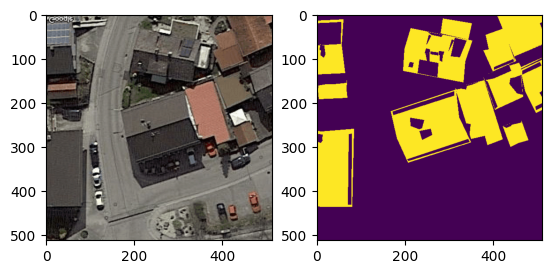

In [29]:
# Display some image to check the split was done correctly

i = 17

plt.subplot(1, 2, 1)
plt.imshow(X_train_augmented[i])

plt.subplot(1, 2, 2)
plt.imshow(Y_train_seg_augmented[i])

## Define the metric to evaluate the model performance

In [30]:
# Intersection over union

def IoU(Target, Prediction):
    Union = 0
    Intersection = 0
    for i in range(len(Target)):
        Union += ((Target[i] == 1) | (Prediction[i] == 1)).sum()
        Intersection += ((Target[i] == 1) & (Prediction[i] == 1)).sum()
    return Intersection/Union

So far we divided our data into training, testing and validation sets using the split 80/10/10.

We created a mask which contains area of rooftop without any segments and we difined a metric for evaluating our models. 

Next, we will built four models for making predictions. We will use the truncated training data to first train these models. We will then evaluate them on the validation data. Guided by their performance, we will change the hyperparameters of the model. We will them train the model on the training data which includes the validation set (denoted with _t) and we will evaluate the performance on the test data.

## Define the training function

In [31]:
# Define model training function

def model_training(Model, X_train, Y_train, X_valid, Y_valid, path_to_save_model, path_to_logs, Batch_size, Epochs):
    
    Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stops 
    callbacks = [tf.keras.callbacks.TensorBoard(log_dir = path_to_logs), tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'), tf.keras.callbacks.ModelCheckpoint(path_to_save_model, verbose = 1, save_best_only= True)]
    
    # Fit the model
    Model.fit(X_train, Y_train, validation_data = (X_valid, Y_valid), batch_size = Batch_size, epochs = Epochs, callbacks = callbacks)

    return Model

## U-net

In [32]:
# Define the achitecture of a U-net

def Unet():
    inputs_Unet = tf.keras.layers.Input((img_width, img_height, img_channels))

    # Scale the inputs between 0 and 1
    s = tf.keras.layers.Lambda(lambda x: x/255)(inputs_Unet)
    s = tf.cast(s, dtype = tf.float16) # Limit the precision

    # First convolution layer
    c1 = tf.keras.layers.Conv2D(16,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

    # Second convolution layer
    c2 = tf.keras.layers.Conv2D(32,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPool2D((2,2))(c2)

    # Third convolution layer
    c3 = tf.keras.layers.Conv2D(64,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPool2D((2,2))(c3)

    # Fourth convolution layer
    c4 = tf.keras.layers.Conv2D(128,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPool2D((2,2))(c4)

    # Fifth convolution layer
    c5 = tf.keras.layers.Conv2D(256,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(c5)

    # First transpose convolution layer
    u6 = tf.keras.layers.Conv2DTranspose(128,(3,3), strides = (2,2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(c6)

    # Second transpose convolution layer
    u7 = tf.keras.layers.Conv2DTranspose(64,(3,3), strides = (2,2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(c7)

    # Third transpose convolution layer
    u8 = tf.keras.layers.Conv2DTranspose(32,(3,3), strides = (2,2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(c8)

    # Fourth transpose convolution layer
    u9 = tf.keras.layers.Conv2DTranspose(16,(3,3), strides = (2,2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16,(3,3), activation ='relu', kernel_initializer= 'he_normal', padding='same')(c9)

    outputs_Unet = tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[inputs_Unet], outputs = [outputs_Unet])

    return model

In [33]:
# The architecture of the U-net

Unet().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 512, 512, 3)  0           ['lambda[0][0]']                 
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['tf.cast[0][0]']            

In [ ]:
# Data sets used for training:
# 1. X: X_train, Y: Y_train_seg, X_validate: X_val, Y_test: Y_val_seg
# 2. X: X_train_with_val, Y: Y_train_with_val_seg, X_validate: X_test, Y_test: Y_test_seg
# 3. X: X_train_augmented, Y: Y_train_seg_augmented, X_validate: X_val, Y_test: Y_val_seg
# 3. X: X_augmented, Y: Y_seg_augmented, X_validate: X_test, Y_test: Y_test_seg

In [ ]:
# First training of Unet

p1 = multiprocessing.Process(target = model_training(Unet(), X_train, Y_train_seg, X_val, Y_val_seg, "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_1\\Weights", "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_1\\Logs", Batch_size = 16, Epochs = 25))
p1.start()
p1.join()

Epoch 1/25
94/94 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.8438
Epoch 1: val_loss improved from inf to 0.39937, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 38s 305ms/step - loss: 0.3717 - accuracy: 0.8438 - val_loss: 0.3994 - val_accuracy: 0.7790
Epoch 2/25
94/94 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.8950
Epoch 2: val_loss improved from 0.39937 to 0.36270, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 287ms/step - loss: 0.2543 - accuracy: 0.8950 - val_loss: 0.3627 - val_accuracy: 0.7914
Epoch 3/25
94/94 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.9102
Epoch 3: val_loss did not improve from 0.36270
94/94 [==============================] - 25s 264ms/step - loss: 0.2243 - accuracy: 0.9102 - val_loss: 0.4067 - val_accuracy: 0.7980
Epoch 4/25
94/94 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9245
Epoch 4: val_loss improved from 0.36270 to 0.22053, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 286ms/step - loss: 0.1884 - accuracy: 0.9245 - val_loss: 0.2205 - val_accuracy: 0.9162
Epoch 5/25
94/94 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.9328
Epoch 5: val_loss did not improve from 0.22053
94/94 [==============================] - 25s 265ms/step - loss: 0.1674 - accuracy: 0.9328 - val_loss: 0.3699 - val_accuracy: 0.8350
Epoch 6/25
94/94 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9391
Epoch 6: val_loss improved from 0.22053 to 0.19073, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 289ms/step - loss: 0.1531 - accuracy: 0.9391 - val_loss: 0.1907 - val_accuracy: 0.9243
Epoch 7/25
94/94 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9414
Epoch 7: val_loss did not improve from 0.19073
94/94 [==============================] - 25s 266ms/step - loss: 0.1466 - accuracy: 0.9414 - val_loss: 0.1945 - val_accuracy: 0.9268
Epoch 8/25
94/94 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9451
Epoch 8: val_loss improved from 0.19073 to 0.14153, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 287ms/step - loss: 0.1373 - accuracy: 0.9451 - val_loss: 0.1415 - val_accuracy: 0.9450
Epoch 9/25
94/94 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.9485
Epoch 9: val_loss improved from 0.14153 to 0.13757, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 289ms/step - loss: 0.1314 - accuracy: 0.9485 - val_loss: 0.1376 - val_accuracy: 0.9467
Epoch 10/25
94/94 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9523
Epoch 10: val_loss improved from 0.13757 to 0.12085, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 285ms/step - loss: 0.1208 - accuracy: 0.9523 - val_loss: 0.1209 - val_accuracy: 0.9530
Epoch 11/25
94/94 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9503
Epoch 11: val_loss did not improve from 0.12085
94/94 [==============================] - 24s 260ms/step - loss: 0.1256 - accuracy: 0.9503 - val_loss: 0.1224 - val_accuracy: 0.9507
Epoch 12/25
94/94 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9570
Epoch 12: val_loss improved from 0.12085 to 0.10801, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 289ms/step - loss: 0.1089 - accuracy: 0.9570 - val_loss: 0.1080 - val_accuracy: 0.9577
Epoch 13/25
94/94 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9600
Epoch 13: val_loss improved from 0.10801 to 0.10604, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 290ms/step - loss: 0.1006 - accuracy: 0.9600 - val_loss: 0.1060 - val_accuracy: 0.9586
Epoch 14/25
94/94 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.9605
Epoch 14: val_loss did not improve from 0.10604
94/94 [==============================] - 25s 265ms/step - loss: 0.0992 - accuracy: 0.9605 - val_loss: 0.1229 - val_accuracy: 0.9521
Epoch 15/25
94/94 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9638
Epoch 15: val_loss improved from 0.10604 to 0.09644, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 287ms/step - loss: 0.0909 - accuracy: 0.9638 - val_loss: 0.0964 - val_accuracy: 0.9628
Epoch 16/25
94/94 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9664
Epoch 16: val_loss improved from 0.09644 to 0.09288, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 288ms/step - loss: 0.0843 - accuracy: 0.9664 - val_loss: 0.0929 - val_accuracy: 0.9630
Epoch 17/25
94/94 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 0.9679
Epoch 17: val_loss improved from 0.09288 to 0.08531, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 286ms/step - loss: 0.0809 - accuracy: 0.9679 - val_loss: 0.0853 - val_accuracy: 0.9667
Epoch 18/25
94/94 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9697
Epoch 18: val_loss did not improve from 0.08531
94/94 [==============================] - 25s 266ms/step - loss: 0.0763 - accuracy: 0.9697 - val_loss: 0.0876 - val_accuracy: 0.9664
Epoch 19/25
94/94 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9695
Epoch 19: val_loss improved from 0.08531 to 0.08358, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 286ms/step - loss: 0.0764 - accuracy: 0.9695 - val_loss: 0.0836 - val_accuracy: 0.9673
Epoch 20/25
94/94 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9713
Epoch 20: val_loss did not improve from 0.08358
94/94 [==============================] - 25s 266ms/step - loss: 0.0720 - accuracy: 0.9713 - val_loss: 0.0937 - val_accuracy: 0.9658
Epoch 21/25
94/94 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9724
Epoch 21: val_loss improved from 0.08358 to 0.08157, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 289ms/step - loss: 0.0691 - accuracy: 0.9724 - val_loss: 0.0816 - val_accuracy: 0.9684
Epoch 22/25
94/94 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9733
Epoch 22: val_loss improved from 0.08157 to 0.07844, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 288ms/step - loss: 0.0668 - accuracy: 0.9733 - val_loss: 0.0784 - val_accuracy: 0.9697
Epoch 23/25
94/94 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9740
Epoch 23: val_loss did not improve from 0.07844
94/94 [==============================] - 25s 268ms/step - loss: 0.0647 - accuracy: 0.9740 - val_loss: 0.0822 - val_accuracy: 0.9693
Epoch 24/25
94/94 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9744
Epoch 24: val_loss improved from 0.07844 to 0.07408, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_1\Weights\assets


94/94 [==============================] - 27s 289ms/step - loss: 0.0636 - accuracy: 0.9744 - val_loss: 0.0741 - val_accuracy: 0.9718
Epoch 25/25
94/94 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9746
Epoch 25: val_loss did not improve from 0.07408
94/94 [==============================] - 25s 267ms/step - loss: 0.0631 - accuracy: 0.9746 - val_loss: 0.0774 - val_accuracy: 0.9707


INFO:tensorflow:Assets written to: ram://a2bfc558-7e7b-41f0-9289-3f297fdf35ce/assets


INFO:tensorflow:Assets written to: ram://a2bfc558-7e7b-41f0-9289-3f297fdf35ce/assets


In [ ]:
# Second training of Unet

p2 = multiprocessing.Process(target = model_training(Unet(), X_train_with_val, Y_train_with_val_seg, X_test, Y_test_seg, "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_2\\Weights", "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_2\\Logs", Batch_size = 16, Epochs = 25))
p2.start()
p2.join()

Epoch 1/25
106/106 [==============================] - ETA: 0s - loss: 0.4472 - accuracy: 0.8239
Epoch 1: val_loss improved from inf to 0.31620, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 33s 308ms/step - loss: 0.4472 - accuracy: 0.8239 - val_loss: 0.3162 - val_accuracy: 0.8839
Epoch 2/25
106/106 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.8935
Epoch 2: val_loss improved from 0.31620 to 0.24705, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 30s 285ms/step - loss: 0.2708 - accuracy: 0.8935 - val_loss: 0.2471 - val_accuracy: 0.9066
Epoch 3/25
106/106 [==============================] - ETA: 0s - loss: 0.2247 - accuracy: 0.9106
Epoch 3: val_loss did not improve from 0.24705
106/106 [==============================] - 28s 268ms/step - loss: 0.2247 - accuracy: 0.9106 - val_loss: 0.5001 - val_accuracy: 0.7192
Epoch 4/25
106/106 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9208
Epoch 4: val_loss did not improve from 0.24705
106/106 [==============================] - 27s 259ms/step - loss: 0.1965 - accuracy: 0.9208 - val_loss: 0.2787 - val_accuracy: 0.8800
Epoch 5/25
106/106 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9315
Epoch 5: val_loss improved from 0.24705 to 0.20659, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 30s 281ms/step - loss: 0.1709 - accuracy: 0.9315 - val_loss: 0.2066 - val_accuracy: 0.9139
Epoch 6/25
106/106 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9387
Epoch 6: val_loss improved from 0.20659 to 0.16744, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 30s 281ms/step - loss: 0.1528 - accuracy: 0.9387 - val_loss: 0.1674 - val_accuracy: 0.9376
Epoch 7/25
106/106 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9424
Epoch 7: val_loss did not improve from 0.16744
106/106 [==============================] - 28s 261ms/step - loss: 0.1435 - accuracy: 0.9424 - val_loss: 0.2000 - val_accuracy: 0.9260
Epoch 8/25
106/106 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9465
Epoch 8: val_loss improved from 0.16744 to 0.14966, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 30s 283ms/step - loss: 0.1339 - accuracy: 0.9465 - val_loss: 0.1497 - val_accuracy: 0.9408
Epoch 9/25
106/106 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9492
Epoch 9: val_loss did not improve from 0.14966
106/106 [==============================] - 28s 262ms/step - loss: 0.1275 - accuracy: 0.9492 - val_loss: 0.1609 - val_accuracy: 0.9360
Epoch 10/25
106/106 [==============================] - ETA: 0s - loss: 0.1176 - accuracy: 0.9529
Epoch 10: val_loss improved from 0.14966 to 0.12782, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 30s 282ms/step - loss: 0.1176 - accuracy: 0.9529 - val_loss: 0.1278 - val_accuracy: 0.9488
Epoch 11/25
106/106 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9548
Epoch 11: val_loss did not improve from 0.12782
106/106 [==============================] - 28s 262ms/step - loss: 0.1130 - accuracy: 0.9548 - val_loss: 0.1452 - val_accuracy: 0.9415
Epoch 12/25
106/106 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9578
Epoch 12: val_loss improved from 0.12782 to 0.11380, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 30s 283ms/step - loss: 0.1062 - accuracy: 0.9578 - val_loss: 0.1138 - val_accuracy: 0.9556
Epoch 13/25
106/106 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9607
Epoch 13: val_loss did not improve from 0.11380
106/106 [==============================] - 28s 262ms/step - loss: 0.0986 - accuracy: 0.9607 - val_loss: 0.1396 - val_accuracy: 0.9474
Epoch 14/25
106/106 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9618
Epoch 14: val_loss improved from 0.11380 to 0.10519, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 30s 285ms/step - loss: 0.0960 - accuracy: 0.9618 - val_loss: 0.1052 - val_accuracy: 0.9577
Epoch 15/25
106/106 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9625
Epoch 15: val_loss did not improve from 0.10519
106/106 [==============================] - 28s 266ms/step - loss: 0.0945 - accuracy: 0.9625 - val_loss: 0.1093 - val_accuracy: 0.9588
Epoch 16/25
106/106 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9671
Epoch 16: val_loss improved from 0.10519 to 0.10419, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 30s 285ms/step - loss: 0.0827 - accuracy: 0.9671 - val_loss: 0.1042 - val_accuracy: 0.9611
Epoch 17/25
106/106 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9678
Epoch 17: val_loss did not improve from 0.10419
106/106 [==============================] - 28s 265ms/step - loss: 0.0811 - accuracy: 0.9678 - val_loss: 0.1214 - val_accuracy: 0.9544
Epoch 18/25
106/106 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9682
Epoch 18: val_loss improved from 0.10419 to 0.09232, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 30s 283ms/step - loss: 0.0797 - accuracy: 0.9682 - val_loss: 0.0923 - val_accuracy: 0.9644
Epoch 19/25
106/106 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9683
Epoch 19: val_loss did not improve from 0.09232
106/106 [==============================] - 28s 265ms/step - loss: 0.0795 - accuracy: 0.9683 - val_loss: 0.1014 - val_accuracy: 0.9620
Epoch 20/25
106/106 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9709
Epoch 20: val_loss did not improve from 0.09232
106/106 [==============================] - 28s 265ms/step - loss: 0.0729 - accuracy: 0.9709 - val_loss: 0.1276 - val_accuracy: 0.9526
Epoch 21/25
106/106 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9713
Epoch 21: val_loss improved from 0.09232 to 0.08468, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 30s 283ms/step - loss: 0.0716 - accuracy: 0.9713 - val_loss: 0.0847 - val_accuracy: 0.9684
Epoch 22/25
106/106 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9740
Epoch 22: val_loss did not improve from 0.08468
106/106 [==============================] - 28s 264ms/step - loss: 0.0640 - accuracy: 0.9740 - val_loss: 0.0854 - val_accuracy: 0.9688
Epoch 23/25
106/106 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9750
Epoch 23: val_loss improved from 0.08468 to 0.07948, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 30s 283ms/step - loss: 0.0615 - accuracy: 0.9750 - val_loss: 0.0795 - val_accuracy: 0.9703
Epoch 24/25
106/106 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9757
Epoch 24: val_loss did not improve from 0.07948
106/106 [==============================] - 28s 267ms/step - loss: 0.0597 - accuracy: 0.9757 - val_loss: 0.0831 - val_accuracy: 0.9685
Epoch 25/25
106/106 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.9760
Epoch 25: val_loss improved from 0.07948 to 0.07728, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_2\Weights\assets


106/106 [==============================] - 30s 288ms/step - loss: 0.0587 - accuracy: 0.9760 - val_loss: 0.0773 - val_accuracy: 0.9717


INFO:tensorflow:Assets written to: ram://fb61fa2a-b271-4418-9edf-d74e4e3482b8/assets


INFO:tensorflow:Assets written to: ram://fb61fa2a-b271-4418-9edf-d74e4e3482b8/assets


In [ ]:
# Third training of Unet

p3 = multiprocessing.Process(target = model_training(Unet(), X_train_augmented, Y_train_seg_augmented, X_val, Y_val_seg, "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_3\\Weights", "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_3\\Logs", Batch_size = 16, Epochs = 25))
p3.start()
p3.join()

Epoch 1/25
188/188 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.8671
Epoch 1: val_loss improved from inf to 0.40382, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 62s 280ms/step - loss: 0.3125 - accuracy: 0.8671 - val_loss: 0.4038 - val_accuracy: 0.7801
Epoch 2/25
188/188 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9176
Epoch 2: val_loss improved from 0.40382 to 0.29340, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 270ms/step - loss: 0.2070 - accuracy: 0.9176 - val_loss: 0.2934 - val_accuracy: 0.8591
Epoch 3/25
188/188 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.9346
Epoch 3: val_loss improved from 0.29340 to 0.16210, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 269ms/step - loss: 0.1646 - accuracy: 0.9346 - val_loss: 0.1621 - val_accuracy: 0.9349
Epoch 4/25
188/188 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9405
Epoch 4: val_loss did not improve from 0.16210
188/188 [==============================] - 49s 258ms/step - loss: 0.1510 - accuracy: 0.9405 - val_loss: 0.1633 - val_accuracy: 0.9377
Epoch 5/25
188/188 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9471
Epoch 5: val_loss improved from 0.16210 to 0.15571, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 269ms/step - loss: 0.1336 - accuracy: 0.9471 - val_loss: 0.1557 - val_accuracy: 0.9390
Epoch 6/25
188/188 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9515
Epoch 6: val_loss improved from 0.15571 to 0.13306, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 269ms/step - loss: 0.1227 - accuracy: 0.9515 - val_loss: 0.1331 - val_accuracy: 0.9468
Epoch 7/25
188/188 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9553
Epoch 7: val_loss improved from 0.13306 to 0.11156, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 270ms/step - loss: 0.1124 - accuracy: 0.9553 - val_loss: 0.1116 - val_accuracy: 0.9563
Epoch 8/25
188/188 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9581
Epoch 8: val_loss improved from 0.11156 to 0.11134, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 270ms/step - loss: 0.1052 - accuracy: 0.9581 - val_loss: 0.1113 - val_accuracy: 0.9562
Epoch 9/25
188/188 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9608
Epoch 9: val_loss improved from 0.11134 to 0.10004, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 270ms/step - loss: 0.0984 - accuracy: 0.9608 - val_loss: 0.1000 - val_accuracy: 0.9611
Epoch 10/25
188/188 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9632
Epoch 10: val_loss improved from 0.10004 to 0.09494, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 269ms/step - loss: 0.0924 - accuracy: 0.9632 - val_loss: 0.0949 - val_accuracy: 0.9613
Epoch 11/25
188/188 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9646
Epoch 11: val_loss did not improve from 0.09494
188/188 [==============================] - 49s 259ms/step - loss: 0.0893 - accuracy: 0.9646 - val_loss: 0.1171 - val_accuracy: 0.9558
Epoch 12/25
188/188 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9664
Epoch 12: val_loss improved from 0.09494 to 0.08959, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 270ms/step - loss: 0.0844 - accuracy: 0.9664 - val_loss: 0.0896 - val_accuracy: 0.9651
Epoch 13/25
188/188 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9672
Epoch 13: val_loss did not improve from 0.08959
188/188 [==============================] - 49s 259ms/step - loss: 0.0825 - accuracy: 0.9672 - val_loss: 0.0897 - val_accuracy: 0.9658
Epoch 14/25
188/188 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9695
Epoch 14: val_loss improved from 0.08959 to 0.08772, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 269ms/step - loss: 0.0765 - accuracy: 0.9695 - val_loss: 0.0877 - val_accuracy: 0.9660
Epoch 15/25
188/188 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9709
Epoch 15: val_loss did not improve from 0.08772
188/188 [==============================] - 49s 258ms/step - loss: 0.0726 - accuracy: 0.9709 - val_loss: 0.0903 - val_accuracy: 0.9651
Epoch 16/25
188/188 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9719
Epoch 16: val_loss improved from 0.08772 to 0.07802, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 271ms/step - loss: 0.0701 - accuracy: 0.9719 - val_loss: 0.0780 - val_accuracy: 0.9696
Epoch 17/25
188/188 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9713
Epoch 17: val_loss improved from 0.07802 to 0.07695, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 270ms/step - loss: 0.0722 - accuracy: 0.9713 - val_loss: 0.0770 - val_accuracy: 0.9695
Epoch 18/25
188/188 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9725
Epoch 18: val_loss did not improve from 0.07695
188/188 [==============================] - 49s 258ms/step - loss: 0.0686 - accuracy: 0.9725 - val_loss: 0.0773 - val_accuracy: 0.9696
Epoch 19/25
188/188 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9498
Epoch 19: val_loss did not improve from 0.07695
188/188 [==============================] - 48s 258ms/step - loss: 0.1305 - accuracy: 0.9498 - val_loss: 0.0908 - val_accuracy: 0.9648
Epoch 20/25
188/188 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.9682
Epoch 20: val_loss did not improve from 0.07695
188/188 [==============================] - 48s 258ms/step - loss: 0.0801 - accuracy: 0.9682 - val_loss: 0.0811 - val_accuracy: 0.9683
Epoch 21/25
188/188 [========

INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 50s 268ms/step - loss: 0.0701 - accuracy: 0.9720 - val_loss: 0.0760 - val_accuracy: 0.9704
Epoch 22/25
188/188 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9742
Epoch 22: val_loss improved from 0.07599 to 0.07379, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 51s 268ms/step - loss: 0.0640 - accuracy: 0.9742 - val_loss: 0.0738 - val_accuracy: 0.9714
Epoch 23/25
188/188 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9648
Epoch 23: val_loss did not improve from 0.07379
188/188 [==============================] - 49s 257ms/step - loss: 0.0900 - accuracy: 0.9648 - val_loss: 0.1274 - val_accuracy: 0.9497
Epoch 24/25
188/188 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9707
Epoch 24: val_loss improved from 0.07379 to 0.07344, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 50s 268ms/step - loss: 0.0735 - accuracy: 0.9707 - val_loss: 0.0734 - val_accuracy: 0.9716
Epoch 25/25
188/188 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9755
Epoch 25: val_loss improved from 0.07344 to 0.06948, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_3\Weights\assets


188/188 [==============================] - 50s 267ms/step - loss: 0.0603 - accuracy: 0.9755 - val_loss: 0.0695 - val_accuracy: 0.9731


INFO:tensorflow:Assets written to: ram://83a3745c-8cae-4fd6-8eec-6ec59a69d0b9/assets


INFO:tensorflow:Assets written to: ram://83a3745c-8cae-4fd6-8eec-6ec59a69d0b9/assets


In [ ]:
# Fourth and final training of Unet

p4 = multiprocessing.Process(target = model_training(Unet(), X_augmented, Y_seg_augmented, X_test, Y_test_seg, "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_4\\Weights", "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_4\\Logs", Batch_size = 8, Epochs = 25))
p4.start()
p4.join()

Epoch 1/25
423/423 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8817
Epoch 1: val_loss improved from inf to 0.24479, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 62s 134ms/step - loss: 0.2820 - accuracy: 0.8817 - val_loss: 0.2448 - val_accuracy: 0.8917
Epoch 2/25
423/423 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9292
Epoch 2: val_loss improved from 0.24479 to 0.16044, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 56s 131ms/step - loss: 0.1754 - accuracy: 0.9292 - val_loss: 0.1604 - val_accuracy: 0.9346
Epoch 3/25
423/423 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.9403
Epoch 3: val_loss improved from 0.16044 to 0.13702, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 56s 131ms/step - loss: 0.1508 - accuracy: 0.9403 - val_loss: 0.1370 - val_accuracy: 0.9452
Epoch 4/25
423/423 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9360
Epoch 4: val_loss did not improve from 0.13702
423/423 [==============================] - 54s 126ms/step - loss: 0.1608 - accuracy: 0.9360 - val_loss: 0.1482 - val_accuracy: 0.9422
Epoch 5/25
423/423 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.9424
Epoch 5: val_loss did not improve from 0.13702
423/423 [==============================] - 53s 126ms/step - loss: 0.1467 - accuracy: 0.9424 - val_loss: 0.1398 - val_accuracy: 0.9453
Epoch 6/25
423/423 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9490
Epoch 6: val_loss improved from 0.13702 to 0.12837, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 55s 131ms/step - loss: 0.1296 - accuracy: 0.9490 - val_loss: 0.1284 - val_accuracy: 0.9484
Epoch 7/25
423/423 [==============================] - ETA: 0s - loss: 0.1180 - accuracy: 0.9532
Epoch 7: val_loss improved from 0.12837 to 0.11302, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 55s 130ms/step - loss: 0.1180 - accuracy: 0.9532 - val_loss: 0.1130 - val_accuracy: 0.9543
Epoch 8/25
423/423 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9580
Epoch 8: val_loss improved from 0.11302 to 0.10284, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 56s 132ms/step - loss: 0.1057 - accuracy: 0.9580 - val_loss: 0.1028 - val_accuracy: 0.9595
Epoch 9/25
423/423 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9596
Epoch 9: val_loss improved from 0.10284 to 0.10170, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 56s 132ms/step - loss: 0.1016 - accuracy: 0.9596 - val_loss: 0.1017 - val_accuracy: 0.9596
Epoch 10/25
423/423 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.9627
Epoch 10: val_loss improved from 0.10170 to 0.09585, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 56s 132ms/step - loss: 0.0939 - accuracy: 0.9627 - val_loss: 0.0959 - val_accuracy: 0.9621
Epoch 11/25
423/423 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9591
Epoch 11: val_loss did not improve from 0.09585
423/423 [==============================] - 54s 127ms/step - loss: 0.1040 - accuracy: 0.9591 - val_loss: 0.1103 - val_accuracy: 0.9554
Epoch 12/25
423/423 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9640
Epoch 12: val_loss improved from 0.09585 to 0.09141, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 56s 131ms/step - loss: 0.0903 - accuracy: 0.9640 - val_loss: 0.0914 - val_accuracy: 0.9639
Epoch 13/25
423/423 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9667
Epoch 13: val_loss improved from 0.09141 to 0.08613, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 56s 131ms/step - loss: 0.0835 - accuracy: 0.9667 - val_loss: 0.0861 - val_accuracy: 0.9663
Epoch 14/25
423/423 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9689
Epoch 14: val_loss did not improve from 0.08613
423/423 [==============================] - 54s 127ms/step - loss: 0.0777 - accuracy: 0.9689 - val_loss: 0.0948 - val_accuracy: 0.9646
Epoch 15/25
423/423 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9698
Epoch 15: val_loss did not improve from 0.08613
423/423 [==============================] - 53s 125ms/step - loss: 0.0754 - accuracy: 0.9698 - val_loss: 0.1258 - val_accuracy: 0.9580
Epoch 16/25
423/423 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9696
Epoch 16: val_loss did not improve from 0.08613
423/423 [==============================] - 54s 127ms/step - loss: 0.0760 - accuracy: 0.9696 - val_loss: 0.1125 - val_accuracy: 0.9590
Epoch 17/25
423/423 [========

INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 57s 134ms/step - loss: 0.0732 - accuracy: 0.9707 - val_loss: 0.0772 - val_accuracy: 0.9695
Epoch 18/25
423/423 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 0.9669
Epoch 18: val_loss did not improve from 0.07722
423/423 [==============================] - 53s 126ms/step - loss: 0.0850 - accuracy: 0.9669 - val_loss: 0.1298 - val_accuracy: 0.9492
Epoch 19/25
423/423 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9653
Epoch 19: val_loss did not improve from 0.07722
423/423 [==============================] - 53s 126ms/step - loss: 0.0884 - accuracy: 0.9653 - val_loss: 0.0812 - val_accuracy: 0.9682
Epoch 20/25
423/423 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9718
Epoch 20: val_loss improved from 0.07722 to 0.07547, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 56s 132ms/step - loss: 0.0704 - accuracy: 0.9718 - val_loss: 0.0755 - val_accuracy: 0.9707
Epoch 21/25
423/423 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9730
Epoch 21: val_loss did not improve from 0.07547
423/423 [==============================] - 54s 128ms/step - loss: 0.0670 - accuracy: 0.9730 - val_loss: 0.0764 - val_accuracy: 0.9703
Epoch 22/25
423/423 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9733
Epoch 22: val_loss did not improve from 0.07547
423/423 [==============================] - 54s 128ms/step - loss: 0.0665 - accuracy: 0.9733 - val_loss: 0.0813 - val_accuracy: 0.9695
Epoch 23/25
423/423 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9717
Epoch 23: val_loss improved from 0.07547 to 0.07320, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 56s 132ms/step - loss: 0.0712 - accuracy: 0.9717 - val_loss: 0.0732 - val_accuracy: 0.9710
Epoch 24/25
423/423 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9742
Epoch 24: val_loss did not improve from 0.07320
423/423 [==============================] - 54s 127ms/step - loss: 0.0640 - accuracy: 0.9742 - val_loss: 0.0741 - val_accuracy: 0.9716
Epoch 25/25
423/423 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9739
Epoch 25: val_loss improved from 0.07320 to 0.07214, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\Unet\Model_4\Weights\assets


423/423 [==============================] - 55s 130ms/step - loss: 0.0649 - accuracy: 0.9739 - val_loss: 0.0721 - val_accuracy: 0.9718


INFO:tensorflow:Assets written to: ram://07e1cbac-54e7-4f7b-b75b-955133202267/assets


INFO:tensorflow:Assets written to: ram://07e1cbac-54e7-4f7b-b75b-955133202267/assets


In [ ]:
# Load the models

Unet_1 = keras.models.load_model("C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_1\\Weights") # Model traind without including validation set and without augmentation
Unet_2 = keras.models.load_model("C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_2\\Weights") # Model traind without including validation set and without augmentation
Unet_3 = keras.models.load_model("C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_3\\Weights") # Model traind without including validation set and with augmentation
Unet_4 = keras.models.load_model("C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_4\\Weights") # Model traind with validation set and with augmentation

## Evaluate the Unet models

### Unet 1

In [50]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

Unet_1_preds_val = Unet_1.predict(X_val, verbose=1)
Unet_1_preds_val = (Unet_1_preds_val > 0.55).astype(np.uint8)


6/6 [==============================] - 1s 198ms/step


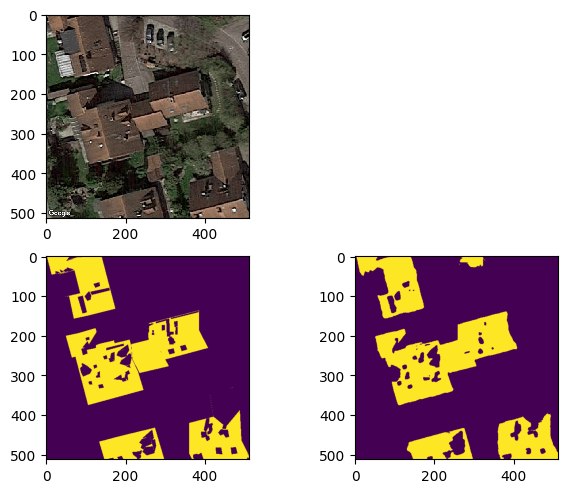

In [ ]:
# Visualise the models' performance out-of-sample

i = 67

plt.subplot(2, 2, 1)
imshow(X_val[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_val_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(Unet_1_preds_val[i]))

In [52]:
Model_performance = IoU(Y_val_seg, Unet_1_preds_val)
Model_performance

0.8695003904264335

### Unet 2

In [66]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

Unet_2_preds_test = Unet_2.predict(X_test, verbose=1)
Unet_2_preds_test = (Unet_2_preds_test > 0.55).astype(np.uint8)

6/6 [==============================] - 1s 198ms/step


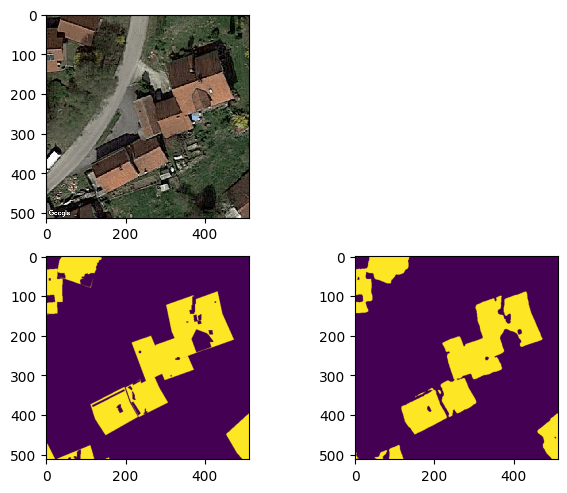

In [ ]:
# Visualise the models' performance out-of-sample

i = 23

plt.subplot(2, 2, 1)
imshow(X_test[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_test_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(Unet_2_preds_test[i]))

In [68]:
Model_performance = IoU(Y_test_seg, Unet_2_preds_test)
Model_performance

0.8657671950379852

### Unet 3

In [58]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

Unet_3_preds_val = Unet_3.predict(X_val, verbose=1)
Unet_3_preds_val = (Unet_3_preds_val > 0.55).astype(np.uint8)

6/6 [==============================] - 1s 208ms/step


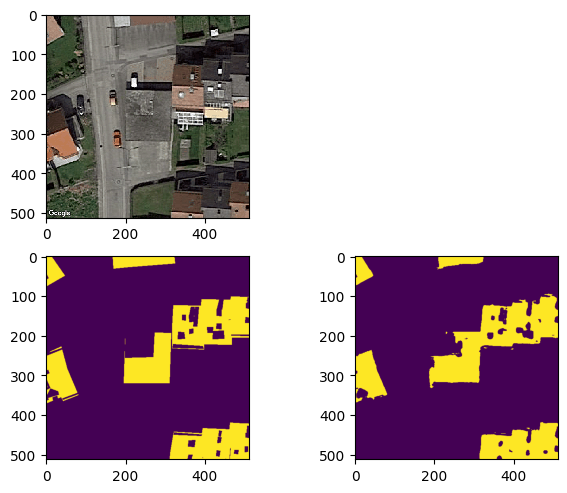

In [ ]:
# Visualise the models' performance out-of-sample

i = 78

plt.subplot(2, 2, 1)
imshow(X_val[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_val_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(Unet_3_preds_val[i]))

In [60]:
Model_performance = IoU(Y_val_seg, Unet_3_preds_val)
Model_performance

0.8756644942157283

### Unet 4

In [36]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

Unet_4_preds_test = Unet_4.predict(X_test, verbose=1)
Unet_4_preds_test = (Unet_4_preds_test > 0.55).astype(np.uint8)

6/6 [==============================] - 10s 726ms/step


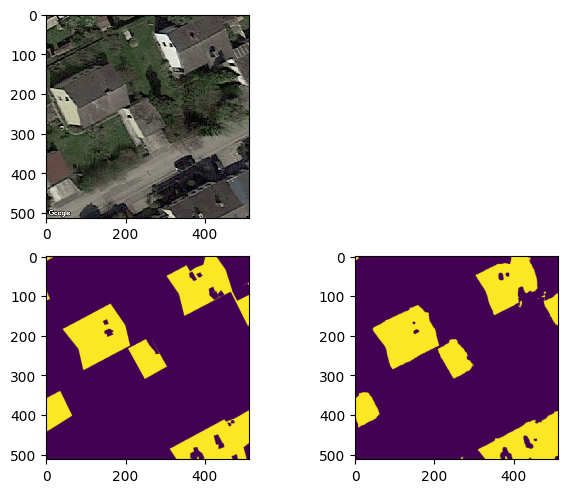

In [ ]:
# Visualise the models' performance out-of-sample

i = 85

plt.subplot(2, 2, 1)
imshow(X_test[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_test_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(Unet_4_preds_test[i]))

In [63]:
Model_performance = IoU(Y_test_seg, Unet_4_preds_test)
Model_performance

0.86459004106735

## Fully Convolutional Network (FCN)

In [32]:
img_width = 512
img_height = 512
img_channels = 3

def FCN():
    inputs_FCN = tf.keras.layers.Input((img_width, img_height, img_channels))
    
    c1 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer = 'he_normal', padding = 'same')(inputs_FCN)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation('relu')(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer = 'he_normal', padding = 'same')(c1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Activation('relu')(c2)

    p1 = tf.keras.layers.MaxPool2D((2,2))(c2)


    c3 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer = 'he_normal', padding = 'same')(p1)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Activation('relu')(c3)

    p2 = tf.keras.layers.MaxPool2D((2,2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer = 'he_normal', padding = 'same')(p2)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Activation('relu')(c4)

    p3 = tf.keras.layers.MaxPool2D((2,2))(c4)
    
    dr1 = tf.keras.layers.Dropout(0.3)(p3)

    c5 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer = 'he_normal', padding = 'same')(dr1)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.Activation('relu')(c5)
    
    d1 = tf.keras.layers.Dense(1024, activation = 'relu')(c5)
    d2 = tf.keras.layers.Dense(1024, activation = 'relu')(d1)

    # Deconvolution Layers (BatchNorm after non-linear activation)

    t1 = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same')(d2)
    t1 = tf.keras.layers.BatchNormalization()(t1)
    t1 = tf.keras.layers.Activation('relu')(t1)
    t1 = tf.keras.layers.UpSampling2D()(t1)

    t2 = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same')(t1)
    t2 = tf.keras.layers.BatchNormalization()(t2)
    t2 = tf.keras.layers.Activation('relu')(t2)

    t3 = tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='same')(t2)
    t3 = tf.keras.layers.BatchNormalization()(t3)
    t3 = tf.keras.layers.Activation('relu')(t3)
    t3 = tf.keras.layers.UpSampling2D()(t3)
    
    t4 = tf.keras.layers.Conv2DTranspose(16, (3, 3), padding='same')(t3)
    t4 = tf.keras.layers.BatchNormalization()(t4)
    t4 = tf.keras.layers.Activation('relu')(t4)
    t4 = tf.keras.layers.UpSampling2D()(t4)


    t5 = tf.keras.layers.Conv2DTranspose(1, (3, 3), padding='same')(t4)
    t5 = tf.keras.layers.BatchNormalization()(t5)
    
    x = tf.keras.layers.Dropout(0.3)(t5)
    x = tf.keras.layers.Activation('sigmoid')(x)

    output_FCN = tf.keras.layers.Reshape((img_width,img_height,1))(x)
    
    model = tf.keras.Model(inputs=inputs_FCN, outputs=output_FCN)
    
    return model

In [61]:
# Uncomment this to see the models' architecture

FCN().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 512, 512, 16)      448       
                                                                 
 batch_normalization_10 (Bat  (None, 512, 512, 16)     64        
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 512, 512, 16)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 512, 512, 32)      4640      
                                                                 
 batch_normalization_11 (Bat  (None, 512, 512, 32)     128       
 chNormalization)                                          

In [ ]:
# Data sets used for training:
# 1. X: X_train, Y: Y_train_seg, X_validate: X_val, Y_test: Y_val_seg
# 2. X: X_train_with_val, Y: Y_train_with_val_seg, X_validate: X_test, Y_test: Y_test_seg
# 3. X: X_train_augmented, Y: Y_train_seg_augmented, X_validate: X_val, Y_test: Y_val_seg
# 3. X: X_augmented, Y: Y_seg_augmented, X_validate: X_test, Y_test: Y_test_seg

(188, 512, 512, 1)

In [ ]:
# First training of FCN

p5 = multiprocessing.Process(target = model_training(FCN(), X_train, Y_train_seg, X_val, Y_val_seg, "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN\\Model_1\\Weights", "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN\\Model_1\\Logs", Batch_size = 16, Epochs = 25))
p5.start()
p5.join()

Epoch 1/25
94/94 [==============================] - ETA: 0s - loss: 0.5173 - accuracy: 0.8629
Epoch 1: val_loss improved from inf to 0.47454, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 283ms/step - loss: 0.5173 - accuracy: 0.8629 - val_loss: 0.4745 - val_accuracy: 0.8954
Epoch 2/25
94/94 [==============================] - ETA: 0s - loss: 0.4669 - accuracy: 0.8852
Epoch 2: val_loss improved from 0.47454 to 0.41664, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 287ms/step - loss: 0.4669 - accuracy: 0.8852 - val_loss: 0.4166 - val_accuracy: 0.9292
Epoch 3/25
94/94 [==============================] - ETA: 0s - loss: 0.4370 - accuracy: 0.8918
Epoch 3: val_loss improved from 0.41664 to 0.38545, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 29s 307ms/step - loss: 0.4370 - accuracy: 0.8918 - val_loss: 0.3855 - val_accuracy: 0.9247
Epoch 4/25
94/94 [==============================] - ETA: 0s - loss: 0.4138 - accuracy: 0.8959
Epoch 4: val_loss improved from 0.38545 to 0.34545, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 28s 294ms/step - loss: 0.4138 - accuracy: 0.8959 - val_loss: 0.3454 - val_accuracy: 0.9409
Epoch 5/25
94/94 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8984
Epoch 5: val_loss improved from 0.34545 to 0.31609, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 286ms/step - loss: 0.3953 - accuracy: 0.8984 - val_loss: 0.3161 - val_accuracy: 0.9464
Epoch 6/25
94/94 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.9004
Epoch 6: val_loss improved from 0.31609 to 0.29024, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 291ms/step - loss: 0.3805 - accuracy: 0.9004 - val_loss: 0.2902 - val_accuracy: 0.9500
Epoch 7/25
94/94 [==============================] - ETA: 0s - loss: 0.3649 - accuracy: 0.9037
Epoch 7: val_loss improved from 0.29024 to 0.27754, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 285ms/step - loss: 0.3649 - accuracy: 0.9037 - val_loss: 0.2775 - val_accuracy: 0.9495
Epoch 8/25
94/94 [==============================] - ETA: 0s - loss: 0.3552 - accuracy: 0.9047
Epoch 8: val_loss improved from 0.27754 to 0.26539, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 283ms/step - loss: 0.3552 - accuracy: 0.9047 - val_loss: 0.2654 - val_accuracy: 0.9520
Epoch 9/25
94/94 [==============================] - ETA: 0s - loss: 0.3470 - accuracy: 0.9050
Epoch 9: val_loss did not improve from 0.26539
94/94 [==============================] - 24s 256ms/step - loss: 0.3470 - accuracy: 0.9050 - val_loss: 0.2773 - val_accuracy: 0.9333
Epoch 10/25
94/94 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.9069
Epoch 10: val_loss improved from 0.26539 to 0.23724, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 283ms/step - loss: 0.3377 - accuracy: 0.9069 - val_loss: 0.2372 - val_accuracy: 0.9546
Epoch 11/25
94/94 [==============================] - ETA: 0s - loss: 0.3309 - accuracy: 0.9076
Epoch 11: val_loss improved from 0.23724 to 0.23023, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 286ms/step - loss: 0.3309 - accuracy: 0.9076 - val_loss: 0.2302 - val_accuracy: 0.9545
Epoch 12/25
94/94 [==============================] - ETA: 0s - loss: 0.3258 - accuracy: 0.9079
Epoch 12: val_loss improved from 0.23023 to 0.21791, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 282ms/step - loss: 0.3258 - accuracy: 0.9079 - val_loss: 0.2179 - val_accuracy: 0.9550
Epoch 13/25
94/94 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0.9102
Epoch 13: val_loss did not improve from 0.21791
94/94 [==============================] - 24s 256ms/step - loss: 0.3171 - accuracy: 0.9102 - val_loss: 0.2190 - val_accuracy: 0.9499
Epoch 14/25
94/94 [==============================] - ETA: 0s - loss: 0.3124 - accuracy: 0.9108
Epoch 14: val_loss improved from 0.21791 to 0.20266, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 293ms/step - loss: 0.3124 - accuracy: 0.9108 - val_loss: 0.2027 - val_accuracy: 0.9585
Epoch 15/25
94/94 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.9109
Epoch 15: val_loss improved from 0.20266 to 0.19213, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 288ms/step - loss: 0.3090 - accuracy: 0.9109 - val_loss: 0.1921 - val_accuracy: 0.9616
Epoch 16/25
94/94 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.9123
Epoch 16: val_loss improved from 0.19213 to 0.18862, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 281ms/step - loss: 0.3032 - accuracy: 0.9123 - val_loss: 0.1886 - val_accuracy: 0.9618
Epoch 17/25
94/94 [==============================] - ETA: 0s - loss: 0.3006 - accuracy: 0.9124
Epoch 17: val_loss improved from 0.18862 to 0.17875, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 285ms/step - loss: 0.3006 - accuracy: 0.9124 - val_loss: 0.1787 - val_accuracy: 0.9611
Epoch 18/25
94/94 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.9140
Epoch 18: val_loss improved from 0.17875 to 0.17403, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 284ms/step - loss: 0.2949 - accuracy: 0.9140 - val_loss: 0.1740 - val_accuracy: 0.9599
Epoch 19/25
94/94 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.9145
Epoch 19: val_loss improved from 0.17403 to 0.16466, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 283ms/step - loss: 0.2920 - accuracy: 0.9145 - val_loss: 0.1647 - val_accuracy: 0.9654
Epoch 20/25
94/94 [==============================] - ETA: 0s - loss: 0.2862 - accuracy: 0.9163
Epoch 20: val_loss did not improve from 0.16466
94/94 [==============================] - 24s 259ms/step - loss: 0.2862 - accuracy: 0.9163 - val_loss: 0.1839 - val_accuracy: 0.9591
Epoch 21/25
94/94 [==============================] - ETA: 0s - loss: 0.2829 - accuracy: 0.9170
Epoch 21: val_loss improved from 0.16466 to 0.15112, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 289ms/step - loss: 0.2829 - accuracy: 0.9170 - val_loss: 0.1511 - val_accuracy: 0.9661
Epoch 22/25
94/94 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.9172
Epoch 22: val_loss improved from 0.15112 to 0.14936, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 289ms/step - loss: 0.2810 - accuracy: 0.9172 - val_loss: 0.1494 - val_accuracy: 0.9674
Epoch 23/25
94/94 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9192
Epoch 23: val_loss improved from 0.14936 to 0.14533, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 286ms/step - loss: 0.2751 - accuracy: 0.9192 - val_loss: 0.1453 - val_accuracy: 0.9670
Epoch 24/25
94/94 [==============================] - ETA: 0s - loss: 0.2726 - accuracy: 0.9198
Epoch 24: val_loss did not improve from 0.14533
94/94 [==============================] - 24s 257ms/step - loss: 0.2726 - accuracy: 0.9198 - val_loss: 0.1555 - val_accuracy: 0.9600
Epoch 25/25
94/94 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.9206
Epoch 25: val_loss improved from 0.14533 to 0.12731, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_1\Weights\assets


94/94 [==============================] - 27s 285ms/step - loss: 0.2695 - accuracy: 0.9206 - val_loss: 0.1273 - val_accuracy: 0.9716


INFO:tensorflow:Assets written to: ram://e76d2f9f-4017-4f99-b723-e96d0a52db05/assets


INFO:tensorflow:Assets written to: ram://e76d2f9f-4017-4f99-b723-e96d0a52db05/assets


In [ ]:
# Second training of FCN

p6 = multiprocessing.Process(target = model_training(FCN(), X_train_with_val, Y_train_with_val_seg, X_test, Y_test_seg, "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN\\Model_2\\Weights", "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN\\Model_2\\Logs", Batch_size = 16, Epochs = 25))
p6.start()
p6.join()

Epoch 1/25
106/106 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.8675
Epoch 1: val_loss improved from inf to 0.49376, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 33s 297ms/step - loss: 0.5120 - accuracy: 0.8675 - val_loss: 0.4938 - val_accuracy: 0.9019
Epoch 2/25
106/106 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.8861
Epoch 2: val_loss improved from 0.49376 to 0.40867, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 281ms/step - loss: 0.4609 - accuracy: 0.8861 - val_loss: 0.4087 - val_accuracy: 0.9212
Epoch 3/25
106/106 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8935
Epoch 3: val_loss improved from 0.40867 to 0.37498, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 29s 278ms/step - loss: 0.4290 - accuracy: 0.8935 - val_loss: 0.3750 - val_accuracy: 0.9260
Epoch 4/25
106/106 [==============================] - ETA: 0s - loss: 0.4044 - accuracy: 0.8976
Epoch 4: val_loss improved from 0.37498 to 0.35194, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 282ms/step - loss: 0.4044 - accuracy: 0.8976 - val_loss: 0.3519 - val_accuracy: 0.9326
Epoch 5/25
106/106 [==============================] - ETA: 0s - loss: 0.3873 - accuracy: 0.8993
Epoch 5: val_loss improved from 0.35194 to 0.31875, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 29s 277ms/step - loss: 0.3873 - accuracy: 0.8993 - val_loss: 0.3187 - val_accuracy: 0.9317
Epoch 6/25
106/106 [==============================] - ETA: 0s - loss: 0.3719 - accuracy: 0.9014
Epoch 6: val_loss improved from 0.31875 to 0.29469, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 282ms/step - loss: 0.3719 - accuracy: 0.9014 - val_loss: 0.2947 - val_accuracy: 0.9449
Epoch 7/25
106/106 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.9046
Epoch 7: val_loss improved from 0.29469 to 0.28539, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 278ms/step - loss: 0.3560 - accuracy: 0.9046 - val_loss: 0.2854 - val_accuracy: 0.9381
Epoch 8/25
106/106 [==============================] - ETA: 0s - loss: 0.3457 - accuracy: 0.9060
Epoch 8: val_loss improved from 0.28539 to 0.25212, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 282ms/step - loss: 0.3457 - accuracy: 0.9060 - val_loss: 0.2521 - val_accuracy: 0.9503
Epoch 9/25
106/106 [==============================] - ETA: 0s - loss: 0.3400 - accuracy: 0.9055
Epoch 9: val_loss did not improve from 0.25212
106/106 [==============================] - 27s 258ms/step - loss: 0.3400 - accuracy: 0.9055 - val_loss: 0.2659 - val_accuracy: 0.9426
Epoch 10/25
106/106 [==============================] - ETA: 0s - loss: 0.3310 - accuracy: 0.9070
Epoch 10: val_loss improved from 0.25212 to 0.22538, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 281ms/step - loss: 0.3310 - accuracy: 0.9070 - val_loss: 0.2254 - val_accuracy: 0.9559
Epoch 11/25
106/106 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.9094
Epoch 11: val_loss improved from 0.22538 to 0.21541, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 284ms/step - loss: 0.3215 - accuracy: 0.9094 - val_loss: 0.2154 - val_accuracy: 0.9566
Epoch 12/25
106/106 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.9099
Epoch 12: val_loss improved from 0.21541 to 0.20722, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 278ms/step - loss: 0.3161 - accuracy: 0.9099 - val_loss: 0.2072 - val_accuracy: 0.9568
Epoch 13/25
106/106 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.9112
Epoch 13: val_loss improved from 0.20722 to 0.19558, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 279ms/step - loss: 0.3096 - accuracy: 0.9112 - val_loss: 0.1956 - val_accuracy: 0.9585
Epoch 14/25
106/106 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.9118
Epoch 14: val_loss improved from 0.19558 to 0.18631, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 29s 275ms/step - loss: 0.3052 - accuracy: 0.9118 - val_loss: 0.1863 - val_accuracy: 0.9623
Epoch 15/25
106/106 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.9131
Epoch 15: val_loss improved from 0.18631 to 0.18179, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 279ms/step - loss: 0.2997 - accuracy: 0.9131 - val_loss: 0.1818 - val_accuracy: 0.9612
Epoch 16/25
106/106 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.9134
Epoch 16: val_loss improved from 0.18179 to 0.17602, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 277ms/step - loss: 0.2966 - accuracy: 0.9134 - val_loss: 0.1760 - val_accuracy: 0.9625
Epoch 17/25
106/106 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.9149
Epoch 17: val_loss did not improve from 0.17602
106/106 [==============================] - 27s 255ms/step - loss: 0.2907 - accuracy: 0.9149 - val_loss: 0.1906 - val_accuracy: 0.9498
Epoch 18/25
106/106 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.9114
Epoch 18: val_loss did not improve from 0.17602
106/106 [==============================] - 27s 255ms/step - loss: 0.2974 - accuracy: 0.9114 - val_loss: 0.2292 - val_accuracy: 0.9374
Epoch 19/25
106/106 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.9156
Epoch 19: val_loss improved from 0.17602 to 0.16354, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 279ms/step - loss: 0.2859 - accuracy: 0.9156 - val_loss: 0.1635 - val_accuracy: 0.9626
Epoch 20/25
106/106 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.9172
Epoch 20: val_loss improved from 0.16354 to 0.14727, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 277ms/step - loss: 0.2807 - accuracy: 0.9172 - val_loss: 0.1473 - val_accuracy: 0.9672
Epoch 21/25
106/106 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9190
Epoch 21: val_loss improved from 0.14727 to 0.13788, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 29s 276ms/step - loss: 0.2751 - accuracy: 0.9190 - val_loss: 0.1379 - val_accuracy: 0.9700
Epoch 22/25
106/106 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.9195
Epoch 22: val_loss improved from 0.13788 to 0.13678, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 280ms/step - loss: 0.2724 - accuracy: 0.9195 - val_loss: 0.1368 - val_accuracy: 0.9688
Epoch 23/25
106/106 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.9207
Epoch 23: val_loss improved from 0.13678 to 0.13252, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 29s 275ms/step - loss: 0.2686 - accuracy: 0.9207 - val_loss: 0.1325 - val_accuracy: 0.9676
Epoch 24/25
106/106 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.9217
Epoch 24: val_loss improved from 0.13252 to 0.12726, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 30s 282ms/step - loss: 0.2653 - accuracy: 0.9217 - val_loss: 0.1273 - val_accuracy: 0.9706
Epoch 25/25
106/106 [==============================] - ETA: 0s - loss: 0.2619 - accuracy: 0.9227
Epoch 25: val_loss improved from 0.12726 to 0.11686, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_2\Weights\assets


106/106 [==============================] - 29s 276ms/step - loss: 0.2619 - accuracy: 0.9227 - val_loss: 0.1169 - val_accuracy: 0.9727


INFO:tensorflow:Assets written to: ram://f7a5793a-5256-43e4-ba94-34aaaab5322e/assets


INFO:tensorflow:Assets written to: ram://f7a5793a-5256-43e4-ba94-34aaaab5322e/assets


In [ ]:
# Third training of FCN

p7 = multiprocessing.Process(target = model_training(FCN(), X_train_augmented, Y_train_seg_augmented, X_val, Y_val_seg, "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN\\Model_3\\Weights", "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN\\Model_3\\Logs", Batch_size = 16, Epochs = 25))
p7.start()
p7.join()

Epoch 1/25
188/188 [==============================] - ETA: 0s - loss: 0.4985 - accuracy: 0.8698
Epoch 1: val_loss improved from inf to 0.43111, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 58s 274ms/step - loss: 0.4985 - accuracy: 0.8698 - val_loss: 0.4311 - val_accuracy: 0.9186
Epoch 2/25
188/188 [==============================] - ETA: 0s - loss: 0.4333 - accuracy: 0.8892
Epoch 2: val_loss improved from 0.43111 to 0.33826, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 264ms/step - loss: 0.4333 - accuracy: 0.8892 - val_loss: 0.3383 - val_accuracy: 0.9378
Epoch 3/25
188/188 [==============================] - ETA: 0s - loss: 0.3977 - accuracy: 0.8943
Epoch 3: val_loss improved from 0.33826 to 0.33015, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 266ms/step - loss: 0.3977 - accuracy: 0.8943 - val_loss: 0.3301 - val_accuracy: 0.9031
Epoch 4/25
188/188 [==============================] - ETA: 0s - loss: 0.3720 - accuracy: 0.8981
Epoch 4: val_loss improved from 0.33015 to 0.27775, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 265ms/step - loss: 0.3720 - accuracy: 0.8981 - val_loss: 0.2778 - val_accuracy: 0.9399
Epoch 5/25
188/188 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.9005
Epoch 5: val_loss improved from 0.27775 to 0.25580, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 265ms/step - loss: 0.3537 - accuracy: 0.9005 - val_loss: 0.2558 - val_accuracy: 0.9439
Epoch 6/25
188/188 [==============================] - ETA: 0s - loss: 0.3391 - accuracy: 0.9027
Epoch 6: val_loss improved from 0.25580 to 0.24518, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 266ms/step - loss: 0.3391 - accuracy: 0.9027 - val_loss: 0.2452 - val_accuracy: 0.9394
Epoch 7/25
188/188 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.9041
Epoch 7: val_loss improved from 0.24518 to 0.21041, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 264ms/step - loss: 0.3287 - accuracy: 0.9041 - val_loss: 0.2104 - val_accuracy: 0.9539
Epoch 8/25
188/188 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.9065
Epoch 8: val_loss improved from 0.21041 to 0.19773, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 267ms/step - loss: 0.3179 - accuracy: 0.9065 - val_loss: 0.1977 - val_accuracy: 0.9545
Epoch 9/25
188/188 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.9074
Epoch 9: val_loss improved from 0.19773 to 0.18775, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 266ms/step - loss: 0.3113 - accuracy: 0.9074 - val_loss: 0.1878 - val_accuracy: 0.9564
Epoch 10/25
188/188 [==============================] - ETA: 0s - loss: 0.3043 - accuracy: 0.9089
Epoch 10: val_loss improved from 0.18775 to 0.18268, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 265ms/step - loss: 0.3043 - accuracy: 0.9089 - val_loss: 0.1827 - val_accuracy: 0.9558
Epoch 11/25
188/188 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.9094
Epoch 11: val_loss improved from 0.18268 to 0.16965, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 267ms/step - loss: 0.3002 - accuracy: 0.9094 - val_loss: 0.1697 - val_accuracy: 0.9573
Epoch 12/25
188/188 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.9097
Epoch 12: val_loss improved from 0.16965 to 0.16724, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 266ms/step - loss: 0.2969 - accuracy: 0.9097 - val_loss: 0.1672 - val_accuracy: 0.9540
Epoch 13/25
188/188 [==============================] - ETA: 0s - loss: 0.2894 - accuracy: 0.9121
Epoch 13: val_loss improved from 0.16724 to 0.15733, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 266ms/step - loss: 0.2894 - accuracy: 0.9121 - val_loss: 0.1573 - val_accuracy: 0.9563
Epoch 14/25
188/188 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.9136
Epoch 14: val_loss improved from 0.15733 to 0.13894, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 266ms/step - loss: 0.2841 - accuracy: 0.9136 - val_loss: 0.1389 - val_accuracy: 0.9636
Epoch 15/25
188/188 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.9144
Epoch 15: val_loss improved from 0.13894 to 0.13019, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 266ms/step - loss: 0.2808 - accuracy: 0.9144 - val_loss: 0.1302 - val_accuracy: 0.9654
Epoch 16/25
188/188 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.9144
Epoch 16: val_loss did not improve from 0.13019
188/188 [==============================] - 48s 253ms/step - loss: 0.2793 - accuracy: 0.9144 - val_loss: 0.1365 - val_accuracy: 0.9619
Epoch 17/25
188/188 [==============================] - ETA: 0s - loss: 0.2772 - accuracy: 0.9149
Epoch 17: val_loss did not improve from 0.13019
188/188 [==============================] - 48s 253ms/step - loss: 0.2772 - accuracy: 0.9149 - val_loss: 0.2338 - val_accuracy: 0.9094
Epoch 18/25
188/188 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.9161
Epoch 18: val_loss improved from 0.13019 to 0.12003, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 266ms/step - loss: 0.2735 - accuracy: 0.9161 - val_loss: 0.1200 - val_accuracy: 0.9651
Epoch 19/25
188/188 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.9188
Epoch 19: val_loss improved from 0.12003 to 0.10743, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 264ms/step - loss: 0.2662 - accuracy: 0.9188 - val_loss: 0.1074 - val_accuracy: 0.9697
Epoch 20/25
188/188 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.9199
Epoch 20: val_loss improved from 0.10743 to 0.10300, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 265ms/step - loss: 0.2629 - accuracy: 0.9199 - val_loss: 0.1030 - val_accuracy: 0.9715
Epoch 21/25
188/188 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.9212
Epoch 21: val_loss did not improve from 0.10300
188/188 [==============================] - 48s 252ms/step - loss: 0.2591 - accuracy: 0.9212 - val_loss: 0.1044 - val_accuracy: 0.9691
Epoch 22/25
188/188 [==============================] - ETA: 0s - loss: 0.2575 - accuracy: 0.9216
Epoch 22: val_loss improved from 0.10300 to 0.10276, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 265ms/step - loss: 0.2575 - accuracy: 0.9216 - val_loss: 0.1028 - val_accuracy: 0.9689
Epoch 23/25
188/188 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9227
Epoch 23: val_loss improved from 0.10276 to 0.09005, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_3\Weights\assets


188/188 [==============================] - 50s 265ms/step - loss: 0.2543 - accuracy: 0.9227 - val_loss: 0.0900 - val_accuracy: 0.9742
Epoch 24/25
188/188 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.9231
Epoch 24: val_loss did not improve from 0.09005
188/188 [==============================] - 48s 252ms/step - loss: 0.2528 - accuracy: 0.9231 - val_loss: 0.1235 - val_accuracy: 0.9580
Epoch 25/25
188/188 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.9226
Epoch 25: val_loss did not improve from 0.09005
188/188 [==============================] - 47s 252ms/step - loss: 0.2538 - accuracy: 0.9226 - val_loss: 0.1204 - val_accuracy: 0.9572


INFO:tensorflow:Assets written to: ram://526aabd8-0d0f-4972-afd4-54b7379ca9ff/assets


INFO:tensorflow:Assets written to: ram://526aabd8-0d0f-4972-afd4-54b7379ca9ff/assets


In [ ]:
# Fourth and final training of FCN

p8 = multiprocessing.Process(target = model_training(FCN(), X_augmented, Y_seg_augmented, X_test, Y_test_seg, "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN\\Model_4\\Weights", "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN\\Model_4\\Logs", Batch_size = 16, Epochs = 25))
p8.start()
p8.join()

Epoch 1/25
212/212 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.8716
Epoch 1: val_loss improved from inf to 0.42251, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 59s 275ms/step - loss: 0.4924 - accuracy: 0.8716 - val_loss: 0.4225 - val_accuracy: 0.9193
Epoch 2/25
212/212 [==============================] - ETA: 0s - loss: 0.4249 - accuracy: 0.8915
Epoch 2: val_loss improved from 0.42251 to 0.34288, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 263ms/step - loss: 0.4249 - accuracy: 0.8915 - val_loss: 0.3429 - val_accuracy: 0.9250
Epoch 3/25
212/212 [==============================] - ETA: 0s - loss: 0.3876 - accuracy: 0.8968
Epoch 3: val_loss improved from 0.34288 to 0.32533, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 264ms/step - loss: 0.3876 - accuracy: 0.8968 - val_loss: 0.3253 - val_accuracy: 0.9311
Epoch 4/25
212/212 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.9005
Epoch 4: val_loss improved from 0.32533 to 0.26689, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 264ms/step - loss: 0.3613 - accuracy: 0.9005 - val_loss: 0.2669 - val_accuracy: 0.9421
Epoch 5/25
212/212 [==============================] - ETA: 0s - loss: 0.3440 - accuracy: 0.9027
Epoch 5: val_loss improved from 0.26689 to 0.24349, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 265ms/step - loss: 0.3440 - accuracy: 0.9027 - val_loss: 0.2435 - val_accuracy: 0.9483
Epoch 6/25
212/212 [==============================] - ETA: 0s - loss: 0.3298 - accuracy: 0.9048
Epoch 6: val_loss did not improve from 0.24349
212/212 [==============================] - 53s 251ms/step - loss: 0.3298 - accuracy: 0.9048 - val_loss: 0.2440 - val_accuracy: 0.9401
Epoch 7/25
212/212 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.9054
Epoch 7: val_loss improved from 0.24349 to 0.21207, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 262ms/step - loss: 0.3214 - accuracy: 0.9054 - val_loss: 0.2121 - val_accuracy: 0.9488
Epoch 8/25
212/212 [==============================] - ETA: 0s - loss: 0.3118 - accuracy: 0.9074
Epoch 8: val_loss improved from 0.21207 to 0.19313, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 263ms/step - loss: 0.3118 - accuracy: 0.9074 - val_loss: 0.1931 - val_accuracy: 0.9558
Epoch 9/25
212/212 [==============================] - ETA: 0s - loss: 0.3029 - accuracy: 0.9094
Epoch 9: val_loss improved from 0.19313 to 0.17906, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 263ms/step - loss: 0.3029 - accuracy: 0.9094 - val_loss: 0.1791 - val_accuracy: 0.9565
Epoch 10/25
212/212 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.9106
Epoch 10: val_loss improved from 0.17906 to 0.16796, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 262ms/step - loss: 0.2969 - accuracy: 0.9106 - val_loss: 0.1680 - val_accuracy: 0.9572
Epoch 11/25
212/212 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.9112
Epoch 11: val_loss improved from 0.16796 to 0.15752, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 264ms/step - loss: 0.2932 - accuracy: 0.9112 - val_loss: 0.1575 - val_accuracy: 0.9605
Epoch 12/25
212/212 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.9120
Epoch 12: val_loss did not improve from 0.15752
212/212 [==============================] - 54s 253ms/step - loss: 0.2889 - accuracy: 0.9120 - val_loss: 0.1619 - val_accuracy: 0.9548
Epoch 13/25
212/212 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.9143
Epoch 13: val_loss improved from 0.15752 to 0.13958, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 264ms/step - loss: 0.2817 - accuracy: 0.9143 - val_loss: 0.1396 - val_accuracy: 0.9626
Epoch 14/25
212/212 [==============================] - ETA: 0s - loss: 0.2774 - accuracy: 0.9155
Epoch 14: val_loss improved from 0.13958 to 0.13611, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 264ms/step - loss: 0.2774 - accuracy: 0.9155 - val_loss: 0.1361 - val_accuracy: 0.9616
Epoch 15/25
212/212 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.9145
Epoch 15: val_loss improved from 0.13611 to 0.13505, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 262ms/step - loss: 0.2786 - accuracy: 0.9145 - val_loss: 0.1351 - val_accuracy: 0.9633
Epoch 16/25
212/212 [==============================] - ETA: 0s - loss: 0.2703 - accuracy: 0.9175
Epoch 16: val_loss improved from 0.13505 to 0.12395, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 264ms/step - loss: 0.2703 - accuracy: 0.9175 - val_loss: 0.1239 - val_accuracy: 0.9643
Epoch 17/25
212/212 [==============================] - ETA: 0s - loss: 0.2663 - accuracy: 0.9187
Epoch 17: val_loss improved from 0.12395 to 0.11267, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 263ms/step - loss: 0.2663 - accuracy: 0.9187 - val_loss: 0.1127 - val_accuracy: 0.9675
Epoch 18/25
212/212 [==============================] - ETA: 0s - loss: 0.2622 - accuracy: 0.9201
Epoch 18: val_loss did not improve from 0.11267
212/212 [==============================] - 53s 250ms/step - loss: 0.2622 - accuracy: 0.9201 - val_loss: 0.1199 - val_accuracy: 0.9629
Epoch 19/25
212/212 [==============================] - ETA: 0s - loss: 0.2605 - accuracy: 0.9205
Epoch 19: val_loss did not improve from 0.11267
212/212 [==============================] - 53s 250ms/step - loss: 0.2605 - accuracy: 0.9205 - val_loss: 0.3073 - val_accuracy: 0.8928
Epoch 20/25
212/212 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.9200
Epoch 20: val_loss improved from 0.11267 to 0.09996, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 55s 260ms/step - loss: 0.2613 - accuracy: 0.9200 - val_loss: 0.1000 - val_accuracy: 0.9707
Epoch 21/25
212/212 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9221
Epoch 21: val_loss improved from 0.09996 to 0.09919, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 261ms/step - loss: 0.2556 - accuracy: 0.9221 - val_loss: 0.0992 - val_accuracy: 0.9695
Epoch 22/25
212/212 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.9231
Epoch 22: val_loss improved from 0.09919 to 0.09245, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 262ms/step - loss: 0.2527 - accuracy: 0.9231 - val_loss: 0.0925 - val_accuracy: 0.9716
Epoch 23/25
212/212 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.9237
Epoch 23: val_loss improved from 0.09245 to 0.08690, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 264ms/step - loss: 0.2507 - accuracy: 0.9237 - val_loss: 0.0869 - val_accuracy: 0.9740
Epoch 24/25
212/212 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.9243
Epoch 24: val_loss did not improve from 0.08690
212/212 [==============================] - 54s 252ms/step - loss: 0.2488 - accuracy: 0.9243 - val_loss: 0.0898 - val_accuracy: 0.9715
Epoch 25/25
212/212 [==============================] - ETA: 0s - loss: 0.2476 - accuracy: 0.9247
Epoch 25: val_loss improved from 0.08690 to 0.08188, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN\Model_4\Weights\assets


212/212 [==============================] - 56s 262ms/step - loss: 0.2476 - accuracy: 0.9247 - val_loss: 0.0819 - val_accuracy: 0.9747


INFO:tensorflow:Assets written to: ram://4ab04483-4b87-4a53-80ff-f2c109753a76/assets


INFO:tensorflow:Assets written to: ram://4ab04483-4b87-4a53-80ff-f2c109753a76/assets


In [ ]:
# Load the models
# Models weights are given on GitHub

FCN_1 = keras.models.load_model("C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN\\Model_1\\Weights")
FCN_2 = keras.models.load_model("C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN\\Model_2\\Weights") # Model traind without including validation set and without augmentation
FCN_3 = keras.models.load_model("C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN\\Model_3\\Weights") # Model traind without including validation set and with augmentation
FCN_4 = keras.models.load_model("C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\Unet\\Model_4\\Weights") # Model traind with validation set and with augmentation

## Evaluate FCN performance

### FCN 1

In [83]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

FCN_1_preds_val = FCN_1.predict(X_val, verbose=1)
FCN_1_preds_val = (FCN_1_preds_val > 0.45).astype(np.uint8)

6/6 [==============================] - 1s 130ms/step


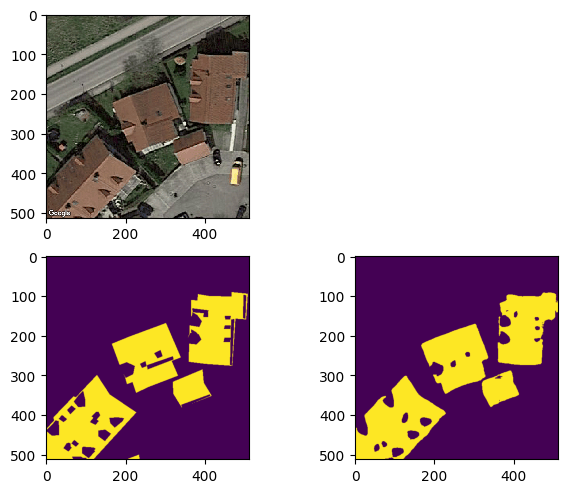

In [ ]:
# Visualise the models' performance out-of-sample

i = 21

plt.subplot(2, 2, 1)
imshow(X_val[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_val_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(FCN_1_preds_val[i]))

In [85]:
Model_performance = IoU(Y_val_seg, FCN_1_preds_val)
Model_performance

0.8673303401673448

### FCN 2

In [88]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

FCN_2_preds_test = FCN_2.predict(X_test, verbose=1)
FCN_2_preds_test = (FCN_2_preds_test > 0.45).astype(np.uint8)

6/6 [==============================] - 1s 130ms/step


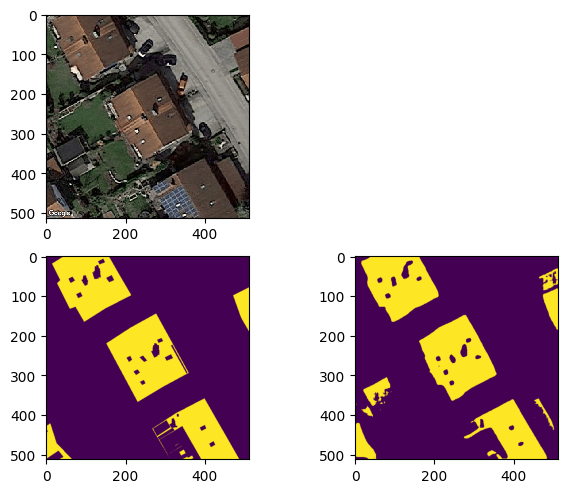

In [ ]:
# Visualise the models performance out-of-sample

i = 89

plt.subplot(2, 2, 1)
imshow(X_test[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_test_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(FCN_2_preds_test[i]))

In [90]:
Model_performance = IoU(Y_test_seg, FCN_2_preds_test)
Model_performance

0.8669512459686939

### FCN 3

In [50]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

FCN_3_preds_val = FCN_3.predict(X_val, verbose=1)
FCN_3_preds_val = (FCN_3_preds_val > 0.45).astype(np.uint8)

6/6 [==============================] - 1s 132ms/step


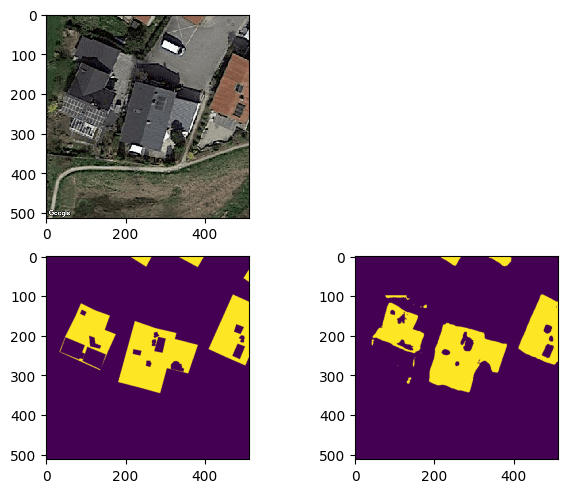

In [ ]:
# Visualise the models' performance out-of-sample

i = 23

plt.subplot(2, 2, 1)
imshow(X_val[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_val_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(FCN_3_preds_val[i]))

In [52]:
Model_performance = IoU(Y_val_seg, FCN_3_preds_val)
Model_performance

0.8786081123096231

### FCN 4

In [59]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

FCN_4_preds_test = FCN_4.predict(X_test, verbose=1)
FCN_4_preds_test = (FCN_4_preds_test > 0.45).astype(np.uint8)

6/6 [==============================] - 1s 210ms/step


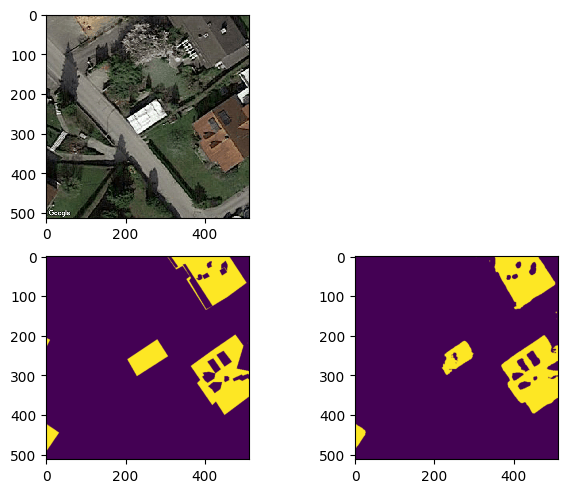

In [ ]:
# Visualise the models' performance out-of-sample

i = 23*2

plt.subplot(2, 2, 1)
imshow(X_test[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_test_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(FCN_4_preds_test[i]))

In [61]:
Model_performance = IoU(Y_test_seg, FCN_4_preds_test)
Model_performance

0.8648622733964018

## Deeper FCN model

In [32]:
img_width = 512
img_height = 512
img_channels = 3

def FCN_deep():
    # Encoding layer
    inputs_FCN = tf.keras.layers.Input((img_width, img_height, img_channels))

    c1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same',strides= (1,1))(inputs_FCN)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Activation('relu')(c1)
    
    c2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(c1)
    c2 = tf.keras.layers.BatchNormalization()(c2)
    c2 = tf.keras.layers.Activation('relu')(c2)
    c2 = tf.keras.layers.MaxPooling2D()(c2)
    c2 = tf.keras.layers.Dropout(0.25)(c2)
    
    c3 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(c2)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Activation('relu')(c3)
    
    c4 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(c3)
    c4 = tf.keras.layers.BatchNormalization()(c4)
    c4 = tf.keras.layers.Activation('relu')(c4)
    c4 = tf.keras.layers.MaxPooling2D()(c4)
    c4 = tf.keras.layers.Dropout(0.25)(c4)

    c5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(c4)
    c5 = tf.keras.layers.BatchNormalization(name='bn5')(c5)
    c5 = tf.keras.layers.Activation('relu')(c5)
    
    c6 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(c5)
    c6 = tf.keras.layers.BatchNormalization()(c6)
    c6 = tf.keras.layers.Activation('relu')(c6)
    
    c7 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(c6)
    c7 = tf.keras.layers.BatchNormalization()(c7)
    c7 = tf.keras.layers.Activation('relu')(c7)
    c7 = tf.keras.layers.MaxPooling2D()(c7)
    c7 = tf.keras.layers.Dropout(0.25)(c7)

    c8 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(c7)
    c8 = tf.keras.layers.BatchNormalization()(c8)
    c8 = tf.keras.layers.Activation('relu')(c8)
    
    c9 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(c8)
    c9 = tf.keras.layers.BatchNormalization()(c9)
    c9 = tf.keras.layers.Activation('relu')(c9)
    
    c10 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(c9)
    c10 = tf.keras.layers.BatchNormalization()(c10)
    c10 = tf.keras.layers.Activation('relu')(c10)
    c10 = tf.keras.layers.MaxPooling2D()(c10)
    c10 = tf.keras.layers.Dropout(0.25)(c10)
    
    c11 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(c10)
    c11 = tf.keras.layers.BatchNormalization()(c11)
    c11 = tf.keras.layers.Activation('relu')(c11)
    
    c12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(c11)
    c12 = tf.keras.layers.BatchNormalization()(c12)
    c12 = tf.keras.layers.Activation('relu')(c12)
    
    c13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(c12)
    c13 = tf.keras.layers.BatchNormalization()(c13)
    c13 = tf.keras.layers.Activation('relu')(c13)
    c13 = tf.keras.layers.MaxPooling2D()(c13)
    c13 = tf.keras.layers.Dropout(0.25)(c13)

    d1 = tf.keras.layers.Dense(1024, activation = 'relu')(c13)
    d2 = tf.keras.layers.Dense(1024, activation = 'relu')(d1)
 
    # Decoding Layer 
    
    t1 = tf.keras.layers.UpSampling2D()(d2)
    t1 = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding='same')(t1)
    t1 = tf.keras.layers.BatchNormalization()(t1)
    t1 = tf.keras.layers.Activation('relu')(t1)
   
    t2 = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding='same')(t1)
    t2 = tf.keras.layers.BatchNormalization()(t2)
    t2 = tf.keras.layers.Activation('relu')(t2)
    
    t3 = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding='same')(t2)
    t3 = tf.keras.layers.BatchNormalization()(t3)
    t3 = tf.keras.layers.Activation('relu')(t3)
    t3 = tf.keras.layers.UpSampling2D()(t3)
    t3 = tf.keras.layers.Dropout(0.25)(t3)
 
    t4 = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding='same')(t3)
    t4 = tf.keras.layers.BatchNormalization()(t4)
    t4 = tf.keras.layers.Activation('relu')(t4)
    
    t5 = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding='same')(t4)
    t5 = tf.keras.layers.BatchNormalization()(t5)
    t5 = tf.keras.layers.Activation('relu')(t5)
    
    t6 = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding='same')(t5)
    t6 = tf.keras.layers.BatchNormalization()(t6)
    t6 = tf.keras.layers.Activation('relu')(t6)
    t6 = tf.keras.layers.Dropout(0.25)(t6)

    t7 = tf.keras.layers.UpSampling2D()(t6)
    t7 = tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='same')(t7)
    t7 = tf.keras.layers.BatchNormalization()(t7)
    t7 = tf.keras.layers.Activation('relu')(t7)
    
    t8 = tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='same')(t7)
    t8 = tf.keras.layers.BatchNormalization()(t8)
    t8 = tf.keras.layers.Activation('relu')(t8)

    t9 = tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='same')(t8)
    t9 = tf.keras.layers.BatchNormalization()(t9)
    t9 = tf.keras.layers.Activation('relu')(t9)
    t9 = tf.keras.layers.Dropout(0.25)(t9)
   

    t10 = tf.keras.layers.UpSampling2D()(t9)
    t10 = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same')(t10)
    t10 = tf.keras.layers.BatchNormalization()(t10)
    t10 = tf.keras.layers.Activation('relu')(t10)
    
    t11 = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same')(t10)
    t11 = tf.keras.layers.BatchNormalization()(t11)
    t11 = tf.keras.layers.Activation('relu')(t11)
    
    
    t12 = tf.keras.layers.UpSampling2D()(t11)
    t12 = tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='same')(t12)
    t12 = tf.keras.layers.BatchNormalization()(t12)
    t12 = tf.keras.layers.Activation('relu')(t12)
    t12 = tf.keras.layers.Dropout(0.3)(t12)

    t13 = tf.keras.layers.Conv2DTranspose(1, (3, 3), padding='same')(t12)
    t13 = tf.keras.layers.BatchNormalization()(t13)
    pred = tf.keras.layers.Activation('sigmoid')(t13)
    
    model = tf.keras.Model(inputs=inputs_FCN, outputs=pred)
    
    return model

In [33]:
FCN_deep().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512, 512, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 512, 512, 32)     128       
 hNormalization)                                             

In [ ]:
# Data sets used for training:
# 1. X: X_train, Y: Y_train_seg, X_validate: X_val, Y_test: Y_val_seg
# 2. X: X_train_with_val, Y: Y_train_with_val_seg, X_validate: X_test, Y_test: Y_test_seg
# 3. X: X_train_augmented, Y: Y_train_seg_augmented, X_validate: X_val, Y_test: Y_val_seg
# 3. X: X_augmented, Y: Y_seg_augmented, X_validate: X_test, Y_test: Y_test_seg

In [36]:
# First training of FCN_deep model

p9 = multiprocessing.Process(target = model_training(FCN_deep(), X_train, Y_train_seg, X_val, Y_val_seg, "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN_deep\\Model_1\\Weights", "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN_deep\\Model_1\\Logs", Batch_size = 4, Epochs = 25))
p9.start()
p9.join()

Epoch 1/25
376/376 [==============================] - ETA: 0s - loss: 0.4558 - accuracy: 0.8840
Epoch 1: val_loss improved from inf to 0.51272, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 88s 210ms/step - loss: 0.4558 - accuracy: 0.8840 - val_loss: 0.5127 - val_accuracy: 0.8678
Epoch 2/25
376/376 [==============================] - ETA: 0s - loss: 0.3373 - accuracy: 0.9166
Epoch 2: val_loss improved from 0.51272 to 0.37193, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 79s 208ms/step - loss: 0.3373 - accuracy: 0.9166 - val_loss: 0.3719 - val_accuracy: 0.8939
Epoch 3/25
376/376 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.9251
Epoch 3: val_loss did not improve from 0.37193
376/376 [==============================] - 73s 193ms/step - loss: 0.2758 - accuracy: 0.9251 - val_loss: 0.5073 - val_accuracy: 0.8482
Epoch 4/25
376/376 [==============================] - ETA: 0s - loss: 0.2401 - accuracy: 0.9287
Epoch 4: val_loss improved from 0.37193 to 0.26235, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 78s 209ms/step - loss: 0.2401 - accuracy: 0.9287 - val_loss: 0.2624 - val_accuracy: 0.9275
Epoch 5/25
376/376 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9333
Epoch 5: val_loss did not improve from 0.26235
376/376 [==============================] - 73s 193ms/step - loss: 0.2124 - accuracy: 0.9333 - val_loss: 0.3504 - val_accuracy: 0.9086
Epoch 6/25
376/376 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9389
Epoch 6: val_loss improved from 0.26235 to 0.21145, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 78s 208ms/step - loss: 0.1887 - accuracy: 0.9389 - val_loss: 0.2115 - val_accuracy: 0.9356
Epoch 7/25
376/376 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9423
Epoch 7: val_loss improved from 0.21145 to 0.19129, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 80s 211ms/step - loss: 0.1718 - accuracy: 0.9423 - val_loss: 0.1913 - val_accuracy: 0.9394
Epoch 8/25
376/376 [==============================] - ETA: 0s - loss: 0.1625 - accuracy: 0.9434
Epoch 8: val_loss improved from 0.19129 to 0.16331, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 80s 212ms/step - loss: 0.1625 - accuracy: 0.9434 - val_loss: 0.1633 - val_accuracy: 0.9438
Epoch 9/25
376/376 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9445
Epoch 9: val_loss improved from 0.16331 to 0.13909, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 79s 211ms/step - loss: 0.1547 - accuracy: 0.9445 - val_loss: 0.1391 - val_accuracy: 0.9498
Epoch 10/25
376/376 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9472
Epoch 10: val_loss improved from 0.13909 to 0.13863, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 79s 210ms/step - loss: 0.1450 - accuracy: 0.9472 - val_loss: 0.1386 - val_accuracy: 0.9517
Epoch 11/25
376/376 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9500
Epoch 11: val_loss did not improve from 0.13863
376/376 [==============================] - 74s 196ms/step - loss: 0.1362 - accuracy: 0.9500 - val_loss: 0.1452 - val_accuracy: 0.9434
Epoch 12/25
376/376 [==============================] - ETA: 0s - loss: 0.1286 - accuracy: 0.9522
Epoch 12: val_loss did not improve from 0.13863
376/376 [==============================] - 74s 196ms/step - loss: 0.1286 - accuracy: 0.9522 - val_loss: 0.1417 - val_accuracy: 0.9500
Epoch 13/25
376/376 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9526
Epoch 13: val_loss improved from 0.13863 to 0.12838, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 80s 212ms/step - loss: 0.1256 - accuracy: 0.9526 - val_loss: 0.1284 - val_accuracy: 0.9534
Epoch 14/25
376/376 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9532
Epoch 14: val_loss improved from 0.12838 to 0.12595, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 80s 212ms/step - loss: 0.1229 - accuracy: 0.9532 - val_loss: 0.1260 - val_accuracy: 0.9526
Epoch 15/25
376/376 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.9537
Epoch 15: val_loss improved from 0.12595 to 0.11684, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 79s 211ms/step - loss: 0.1208 - accuracy: 0.9537 - val_loss: 0.1168 - val_accuracy: 0.9544
Epoch 16/25
376/376 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9585
Epoch 16: val_loss improved from 0.11684 to 0.11600, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 79s 211ms/step - loss: 0.1080 - accuracy: 0.9585 - val_loss: 0.1160 - val_accuracy: 0.9539
Epoch 17/25
376/376 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9582
Epoch 17: val_loss improved from 0.11600 to 0.10761, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 80s 211ms/step - loss: 0.1078 - accuracy: 0.9582 - val_loss: 0.1076 - val_accuracy: 0.9583
Epoch 18/25
376/376 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9559
Epoch 18: val_loss improved from 0.10761 to 0.10636, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 79s 210ms/step - loss: 0.1128 - accuracy: 0.9559 - val_loss: 0.1064 - val_accuracy: 0.9610
Epoch 19/25
376/376 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9601
Epoch 19: val_loss improved from 0.10636 to 0.10398, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 79s 209ms/step - loss: 0.1024 - accuracy: 0.9601 - val_loss: 0.1040 - val_accuracy: 0.9590
Epoch 20/25
376/376 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9629
Epoch 20: val_loss improved from 0.10398 to 0.10054, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_1\Weights\assets


376/376 [==============================] - 78s 207ms/step - loss: 0.0950 - accuracy: 0.9629 - val_loss: 0.1005 - val_accuracy: 0.9595
Epoch 21/25
376/376 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9629
Epoch 21: val_loss did not improve from 0.10054
376/376 [==============================] - 73s 195ms/step - loss: 0.0942 - accuracy: 0.9629 - val_loss: 0.1567 - val_accuracy: 0.9355
Epoch 22/25
376/376 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.9646
Epoch 22: val_loss did not improve from 0.10054
376/376 [==============================] - 75s 199ms/step - loss: 0.0897 - accuracy: 0.9646 - val_loss: 0.1290 - val_accuracy: 0.9514
Epoch 23/25
376/376 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9664
Epoch 23: val_loss did not improve from 0.10054
376/376 [==============================] - 74s 196ms/step - loss: 0.0853 - accuracy: 0.9664 - val_loss: 0.2871 - val_accuracy: 0.8927
Epoch 24/25
376/376 [========

INFO:tensorflow:Assets written to: ram://2713c404-70e7-4f8a-a582-e8101026287d/assets


INFO:tensorflow:Assets written to: ram://2713c404-70e7-4f8a-a582-e8101026287d/assets


In [62]:
# Second training of FCN

p10 = multiprocessing.Process(target = model_training(FCN_deep(), X_train_with_val, Y_train_with_val_seg, X_test, Y_test_seg, "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN_deep\\Model_2\\Weights", "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN_deep\\Model_2\\Logs", Batch_size = 4, Epochs = 25))
p10.start()
p10.join()

Epoch 1/25
423/423 [==============================] - ETA: 0s - loss: 0.4571 - accuracy: 0.8742
Epoch 1: val_loss improved from inf to 5.14070, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


423/423 [==============================] - 91s 212ms/step - loss: 0.4571 - accuracy: 0.8742 - val_loss: 5.1407 - val_accuracy: 0.5082
Epoch 2/25
423/423 [==============================] - ETA: 0s - loss: 0.3307 - accuracy: 0.9147
Epoch 2: val_loss improved from 5.14070 to 0.85955, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


423/423 [==============================] - 88s 208ms/step - loss: 0.3307 - accuracy: 0.9147 - val_loss: 0.8595 - val_accuracy: 0.8583
Epoch 3/25
423/423 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.9253
Epoch 3: val_loss improved from 0.85955 to 0.23679, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


423/423 [==============================] - 89s 209ms/step - loss: 0.2655 - accuracy: 0.9253 - val_loss: 0.2368 - val_accuracy: 0.9262
Epoch 4/25
423/423 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9321
Epoch 4: val_loss did not improve from 0.23679
423/423 [==============================] - 82s 194ms/step - loss: 0.2248 - accuracy: 0.9321 - val_loss: 0.2826 - val_accuracy: 0.8917
Epoch 5/25
423/423 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9375
Epoch 5: val_loss did not improve from 0.23679
423/423 [==============================] - 82s 194ms/step - loss: 0.1965 - accuracy: 0.9375 - val_loss: 0.2374 - val_accuracy: 0.9097
Epoch 6/25
423/423 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.9332
Epoch 6: val_loss improved from 0.23679 to 0.17319, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


423/423 [==============================] - 88s 208ms/step - loss: 0.1931 - accuracy: 0.9332 - val_loss: 0.1732 - val_accuracy: 0.9355
Epoch 7/25
423/423 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.9402
Epoch 7: val_loss did not improve from 0.17319
423/423 [==============================] - 82s 194ms/step - loss: 0.1708 - accuracy: 0.9402 - val_loss: 0.1917 - val_accuracy: 0.9350
Epoch 8/25
423/423 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9449
Epoch 8: val_loss did not improve from 0.17319
423/423 [==============================] - 82s 195ms/step - loss: 0.1549 - accuracy: 0.9449 - val_loss: 0.1783 - val_accuracy: 0.9319
Epoch 9/25
423/423 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9453
Epoch 9: val_loss improved from 0.17319 to 0.14072, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


423/423 [==============================] - 88s 209ms/step - loss: 0.1496 - accuracy: 0.9453 - val_loss: 0.1407 - val_accuracy: 0.9480
Epoch 10/25
423/423 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9486
Epoch 10: val_loss did not improve from 0.14072
423/423 [==============================] - 83s 196ms/step - loss: 0.1390 - accuracy: 0.9486 - val_loss: 0.1570 - val_accuracy: 0.9422
Epoch 11/25
423/423 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9460
Epoch 11: val_loss improved from 0.14072 to 0.13376, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


423/423 [==============================] - 89s 210ms/step - loss: 0.1418 - accuracy: 0.9460 - val_loss: 0.1338 - val_accuracy: 0.9500
Epoch 12/25
423/423 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9514
Epoch 12: val_loss improved from 0.13376 to 0.11878, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


423/423 [==============================] - 89s 209ms/step - loss: 0.1277 - accuracy: 0.9514 - val_loss: 0.1188 - val_accuracy: 0.9546
Epoch 13/25
423/423 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9530
Epoch 13: val_loss did not improve from 0.11878
423/423 [==============================] - 82s 194ms/step - loss: 0.1218 - accuracy: 0.9530 - val_loss: 0.1198 - val_accuracy: 0.9528
Epoch 14/25
423/423 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9533
Epoch 14: val_loss did not improve from 0.11878
423/423 [==============================] - 82s 195ms/step - loss: 0.1210 - accuracy: 0.9533 - val_loss: 0.1350 - val_accuracy: 0.9469
Epoch 15/25
423/423 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9565
Epoch 15: val_loss did not improve from 0.11878
423/423 [==============================] - 82s 194ms/step - loss: 0.1123 - accuracy: 0.9565 - val_loss: 0.1580 - val_accuracy: 0.9360
Epoch 16/25
423/423 [========

INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


423/423 [==============================] - 88s 208ms/step - loss: 0.1052 - accuracy: 0.9588 - val_loss: 0.1108 - val_accuracy: 0.9567
Epoch 18/25
423/423 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9605
Epoch 18: val_loss improved from 0.11078 to 0.10049, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


423/423 [==============================] - 89s 209ms/step - loss: 0.0998 - accuracy: 0.9605 - val_loss: 0.1005 - val_accuracy: 0.9599
Epoch 19/25
423/423 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9619
Epoch 19: val_loss did not improve from 0.10049
423/423 [==============================] - 82s 194ms/step - loss: 0.0963 - accuracy: 0.9619 - val_loss: 0.1396 - val_accuracy: 0.9494
Epoch 20/25
423/423 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9620
Epoch 20: val_loss improved from 0.10049 to 0.09377, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


423/423 [==============================] - 88s 209ms/step - loss: 0.0957 - accuracy: 0.9620 - val_loss: 0.0938 - val_accuracy: 0.9623
Epoch 21/25
423/423 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9647
Epoch 21: val_loss did not improve from 0.09377
423/423 [==============================] - 82s 194ms/step - loss: 0.0886 - accuracy: 0.9647 - val_loss: 0.1220 - val_accuracy: 0.9546
Epoch 22/25
423/423 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9653
Epoch 22: val_loss did not improve from 0.09377
423/423 [==============================] - 82s 194ms/step - loss: 0.0870 - accuracy: 0.9653 - val_loss: 0.0988 - val_accuracy: 0.9613
Epoch 23/25
423/423 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9650
Epoch 23: val_loss improved from 0.09377 to 0.09119, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_2\Weights\assets


423/423 [==============================] - 88s 208ms/step - loss: 0.0880 - accuracy: 0.9650 - val_loss: 0.0912 - val_accuracy: 0.9635
Epoch 24/25
423/423 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9674
Epoch 24: val_loss did not improve from 0.09119
423/423 [==============================] - 82s 194ms/step - loss: 0.0812 - accuracy: 0.9674 - val_loss: 0.0983 - val_accuracy: 0.9607
Epoch 25/25
423/423 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9683
Epoch 25: val_loss did not improve from 0.09119
423/423 [==============================] - 82s 194ms/step - loss: 0.0789 - accuracy: 0.9683 - val_loss: 0.0915 - val_accuracy: 0.9632


INFO:tensorflow:Assets written to: ram://ff6ee443-a958-4fd4-9bcc-d5bb40b4e03f/assets


INFO:tensorflow:Assets written to: ram://ff6ee443-a958-4fd4-9bcc-d5bb40b4e03f/assets


In [31]:
# Third training of FCN

p11 = multiprocessing.Process(target = model_training(FCN_deep(), X_train_augmented, Y_train_seg_augmented, X_val, Y_val_seg, "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN_deep\\Model_3\\Weights", "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN_deep\\Model_3\\Logs", Batch_size = 4, Epochs = 25))
p11.start()
p11.join()

Epoch 1/25
752/752 [==============================] - ETA: 0s - loss: 0.4116 - accuracy: 0.8907
Epoch 1: val_loss improved from inf to 0.35603, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 159s 200ms/step - loss: 0.4116 - accuracy: 0.8907 - val_loss: 0.3560 - val_accuracy: 0.8905
Epoch 2/25
752/752 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.9193
Epoch 2: val_loss improved from 0.35603 to 0.24370, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 200ms/step - loss: 0.2731 - accuracy: 0.9193 - val_loss: 0.2437 - val_accuracy: 0.9324
Epoch 3/25
752/752 [==============================] - ETA: 0s - loss: 0.2156 - accuracy: 0.9291
Epoch 3: val_loss did not improve from 0.24370
752/752 [==============================] - 145s 192ms/step - loss: 0.2156 - accuracy: 0.9291 - val_loss: 0.3135 - val_accuracy: 0.9016
Epoch 4/25
752/752 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9355
Epoch 4: val_loss improved from 0.24370 to 0.18703, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 200ms/step - loss: 0.1836 - accuracy: 0.9355 - val_loss: 0.1870 - val_accuracy: 0.9370
Epoch 5/25
752/752 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.9385
Epoch 5: val_loss improved from 0.18703 to 0.15586, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 200ms/step - loss: 0.1673 - accuracy: 0.9385 - val_loss: 0.1559 - val_accuracy: 0.9436
Epoch 6/25
752/752 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.9418
Epoch 6: val_loss did not improve from 0.15586
752/752 [==============================] - 145s 192ms/step - loss: 0.1536 - accuracy: 0.9418 - val_loss: 0.1586 - val_accuracy: 0.9383
Epoch 7/25
752/752 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9448
Epoch 7: val_loss did not improve from 0.15586
752/752 [==============================] - 144s 192ms/step - loss: 0.1436 - accuracy: 0.9448 - val_loss: 0.2517 - val_accuracy: 0.8831
Epoch 8/25
752/752 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9473
Epoch 8: val_loss improved from 0.15586 to 0.13730, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 200ms/step - loss: 0.1354 - accuracy: 0.9473 - val_loss: 0.1373 - val_accuracy: 0.9471
Epoch 9/25
752/752 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.9465
Epoch 9: val_loss improved from 0.13730 to 0.13658, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 151s 200ms/step - loss: 0.1356 - accuracy: 0.9465 - val_loss: 0.1366 - val_accuracy: 0.9493
Epoch 10/25
752/752 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.9520
Epoch 10: val_loss improved from 0.13658 to 0.11802, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 199ms/step - loss: 0.1216 - accuracy: 0.9520 - val_loss: 0.1180 - val_accuracy: 0.9529
Epoch 11/25
752/752 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.9547
Epoch 11: val_loss improved from 0.11802 to 0.11341, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 200ms/step - loss: 0.1143 - accuracy: 0.9547 - val_loss: 0.1134 - val_accuracy: 0.9542
Epoch 12/25
752/752 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9558
Epoch 12: val_loss did not improve from 0.11341
752/752 [==============================] - 145s 192ms/step - loss: 0.1111 - accuracy: 0.9558 - val_loss: 0.1216 - val_accuracy: 0.9513
Epoch 13/25
752/752 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.9560
Epoch 13: val_loss improved from 0.11341 to 0.11074, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 200ms/step - loss: 0.1096 - accuracy: 0.9560 - val_loss: 0.1107 - val_accuracy: 0.9562
Epoch 14/25
752/752 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9578
Epoch 14: val_loss improved from 0.11074 to 0.10411, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 200ms/step - loss: 0.1050 - accuracy: 0.9578 - val_loss: 0.1041 - val_accuracy: 0.9573
Epoch 15/25
752/752 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9598
Epoch 15: val_loss improved from 0.10411 to 0.10065, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 200ms/step - loss: 0.1001 - accuracy: 0.9598 - val_loss: 0.1006 - val_accuracy: 0.9598
Epoch 16/25
752/752 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9626
Epoch 16: val_loss improved from 0.10065 to 0.09731, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 199ms/step - loss: 0.0928 - accuracy: 0.9626 - val_loss: 0.0973 - val_accuracy: 0.9600
Epoch 17/25
752/752 [==============================] - ETA: 0s - loss: 0.0968 - accuracy: 0.9609
Epoch 17: val_loss did not improve from 0.09731
752/752 [==============================] - 144s 191ms/step - loss: 0.0968 - accuracy: 0.9609 - val_loss: 0.1065 - val_accuracy: 0.9568
Epoch 18/25
752/752 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9617
Epoch 18: val_loss improved from 0.09731 to 0.08696, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 199ms/step - loss: 0.0949 - accuracy: 0.9617 - val_loss: 0.0870 - val_accuracy: 0.9646
Epoch 19/25
752/752 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9622
Epoch 19: val_loss did not improve from 0.08696
752/752 [==============================] - 145s 192ms/step - loss: 0.0937 - accuracy: 0.9622 - val_loss: 0.0876 - val_accuracy: 0.9642
Epoch 20/25
752/752 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9658
Epoch 20: val_loss did not improve from 0.08696
752/752 [==============================] - 145s 192ms/step - loss: 0.0844 - accuracy: 0.9658 - val_loss: 0.0900 - val_accuracy: 0.9633
Epoch 21/25
752/752 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9662
Epoch 21: val_loss did not improve from 0.08696
752/752 [==============================] - 145s 193ms/step - loss: 0.0830 - accuracy: 0.9662 - val_loss: 0.0926 - val_accuracy: 0.9615
Epoch 22/25
752/752 [====

INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 200ms/step - loss: 0.0796 - accuracy: 0.9675 - val_loss: 0.0806 - val_accuracy: 0.9669
Epoch 23/25
752/752 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9672
Epoch 23: val_loss did not improve from 0.08061
752/752 [==============================] - 145s 193ms/step - loss: 0.0803 - accuracy: 0.9672 - val_loss: 0.5032 - val_accuracy: 0.8674
Epoch 24/25
752/752 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.9679
Epoch 24: val_loss improved from 0.08061 to 0.08015, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_3\Weights\assets


752/752 [==============================] - 150s 200ms/step - loss: 0.0786 - accuracy: 0.9679 - val_loss: 0.0801 - val_accuracy: 0.9677
Epoch 25/25
752/752 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9686
Epoch 25: val_loss did not improve from 0.08015
752/752 [==============================] - 144s 191ms/step - loss: 0.0765 - accuracy: 0.9686 - val_loss: 0.0868 - val_accuracy: 0.9642


INFO:tensorflow:Assets written to: ram://6e410bd7-9b03-4cc2-b5f4-22a0809b75d3/assets


INFO:tensorflow:Assets written to: ram://6e410bd7-9b03-4cc2-b5f4-22a0809b75d3/assets


In [34]:
# Fourth and final training of FCN

p12 = multiprocessing.Process(target = model_training(FCN_deep(), X_augmented, Y_seg_augmented, X_test, Y_test_seg, "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN_deep\\Model_4\\Weights", "C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN_deep\\Model_4\\Logs", Batch_size = 4, Epochs = 25))
p12.start()
p12.join()

Epoch 1/25
846/846 [==============================] - ETA: 0s - loss: 0.4649 - accuracy: 0.8537
Epoch 1: val_loss improved from inf to 1.06201, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 191s 200ms/step - loss: 0.4649 - accuracy: 0.8537 - val_loss: 1.0620 - val_accuracy: 0.7201
Epoch 2/25
846/846 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.9167
Epoch 2: val_loss improved from 1.06201 to 0.29966, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 169s 199ms/step - loss: 0.2723 - accuracy: 0.9167 - val_loss: 0.2997 - val_accuracy: 0.8902
Epoch 3/25
846/846 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.9278
Epoch 3: val_loss improved from 0.29966 to 0.20358, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 169s 199ms/step - loss: 0.2130 - accuracy: 0.9278 - val_loss: 0.2036 - val_accuracy: 0.9340
Epoch 4/25
846/846 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.9339
Epoch 4: val_loss did not improve from 0.20358
846/846 [==============================] - 163s 192ms/step - loss: 0.1825 - accuracy: 0.9339 - val_loss: 1.1050 - val_accuracy: 0.7395
Epoch 5/25
846/846 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9395
Epoch 5: val_loss did not improve from 0.20358
846/846 [==============================] - 163s 192ms/step - loss: 0.1623 - accuracy: 0.9395 - val_loss: 0.2262 - val_accuracy: 0.9290
Epoch 6/25
846/846 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9425
Epoch 6: val_loss improved from 0.20358 to 0.16889, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 169s 200ms/step - loss: 0.1503 - accuracy: 0.9425 - val_loss: 0.1689 - val_accuracy: 0.9319
Epoch 7/25
846/846 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9439
Epoch 7: val_loss improved from 0.16889 to 0.16197, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 170s 200ms/step - loss: 0.1436 - accuracy: 0.9439 - val_loss: 0.1620 - val_accuracy: 0.9378
Epoch 8/25
846/846 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9488
Epoch 8: val_loss improved from 0.16197 to 0.12602, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 169s 200ms/step - loss: 0.1308 - accuracy: 0.9488 - val_loss: 0.1260 - val_accuracy: 0.9502
Epoch 9/25
846/846 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 0.9507
Epoch 9: val_loss improved from 0.12602 to 0.11787, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 169s 200ms/step - loss: 0.1246 - accuracy: 0.9507 - val_loss: 0.1179 - val_accuracy: 0.9540
Epoch 10/25
846/846 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9519
Epoch 10: val_loss improved from 0.11787 to 0.11601, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 169s 200ms/step - loss: 0.1211 - accuracy: 0.9519 - val_loss: 0.1160 - val_accuracy: 0.9541
Epoch 11/25
846/846 [==============================] - ETA: 0s - loss: 0.1112 - accuracy: 0.9556
Epoch 11: val_loss improved from 0.11601 to 0.10460, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 169s 200ms/step - loss: 0.1112 - accuracy: 0.9556 - val_loss: 0.1046 - val_accuracy: 0.9578
Epoch 12/25
846/846 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9550
Epoch 12: val_loss did not improve from 0.10460
846/846 [==============================] - 163s 192ms/step - loss: 0.1123 - accuracy: 0.9550 - val_loss: 0.1082 - val_accuracy: 0.9565
Epoch 13/25
846/846 [==============================] - ETA: 0s - loss: 0.1029 - accuracy: 0.9587
Epoch 13: val_loss did not improve from 0.10460
846/846 [==============================] - 163s 193ms/step - loss: 0.1029 - accuracy: 0.9587 - val_loss: 0.1183 - val_accuracy: 0.9543
Epoch 14/25
846/846 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9598
Epoch 14: val_loss improved from 0.10460 to 0.09705, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 171s 202ms/step - loss: 0.1005 - accuracy: 0.9598 - val_loss: 0.0970 - val_accuracy: 0.9615
Epoch 15/25
846/846 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9619
Epoch 15: val_loss did not improve from 0.09705
846/846 [==============================] - 167s 198ms/step - loss: 0.0944 - accuracy: 0.9619 - val_loss: 0.1245 - val_accuracy: 0.9504
Epoch 16/25
846/846 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9625
Epoch 16: val_loss did not improve from 0.09705
846/846 [==============================] - 165s 195ms/step - loss: 0.0928 - accuracy: 0.9625 - val_loss: 0.1084 - val_accuracy: 0.9563
Epoch 17/25
846/846 [==============================] - ETA: 0s - loss: 0.0908 - accuracy: 0.9633
Epoch 17: val_loss improved from 0.09705 to 0.09508, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 172s 203ms/step - loss: 0.0908 - accuracy: 0.9633 - val_loss: 0.0951 - val_accuracy: 0.9633
Epoch 18/25
846/846 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9649
Epoch 18: val_loss improved from 0.09508 to 0.09264, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 173s 204ms/step - loss: 0.0866 - accuracy: 0.9649 - val_loss: 0.0926 - val_accuracy: 0.9630
Epoch 19/25
846/846 [==============================] - ETA: 0s - loss: 0.0842 - accuracy: 0.9657
Epoch 19: val_loss did not improve from 0.09264
846/846 [==============================] - 167s 198ms/step - loss: 0.0842 - accuracy: 0.9657 - val_loss: 0.1087 - val_accuracy: 0.9587
Epoch 20/25
846/846 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9666
Epoch 20: val_loss did not improve from 0.09264
846/846 [==============================] - 164s 194ms/step - loss: 0.0820 - accuracy: 0.9666 - val_loss: 0.2934 - val_accuracy: 0.9222
Epoch 21/25
846/846 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9665
Epoch 21: val_loss did not improve from 0.09264
846/846 [==============================] - 166s 196ms/step - loss: 0.0823 - accuracy: 0.9665 - val_loss: 0.0956 - val_accuracy: 0.9619
Epoch 22/25
846/846 [====

INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 173s 204ms/step - loss: 0.0760 - accuracy: 0.9688 - val_loss: 0.0832 - val_accuracy: 0.9662
Epoch 24/25
846/846 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9698
Epoch 24: val_loss improved from 0.08317 to 0.07951, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 173s 204ms/step - loss: 0.0734 - accuracy: 0.9698 - val_loss: 0.0795 - val_accuracy: 0.9681
Epoch 25/25
846/846 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9705
Epoch 25: val_loss improved from 0.07951 to 0.07934, saving model to C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


INFO:tensorflow:Assets written to: C:\Users\Sven\Desktop\EE981project\Model_new\FCN_deep\Model_4\Weights\assets


846/846 [==============================] - 172s 203ms/step - loss: 0.0714 - accuracy: 0.9705 - val_loss: 0.0793 - val_accuracy: 0.9675


INFO:tensorflow:Assets written to: ram://19ee58a9-fcf7-45fb-8709-e64dfe71a3c4/assets


INFO:tensorflow:Assets written to: ram://19ee58a9-fcf7-45fb-8709-e64dfe71a3c4/assets


In [ ]:
# Load the models
# Models weights are given on GitHub

FCN_deep_1 = keras.models.load_model("C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN_deep\\Model_1\\Weights")
FCN_deep_2 = keras.models.load_model("C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN_deep\\Model_2\\Weights") # Model traind without including validation set and without augmentation
FCN_deep_3 = keras.models.load_model("C:\\Users\\Sven\\Desktop\\EE981project\\Model_new\\FCN_deep\\Model_3\\Weights") # Model traind without including validation set and with augmentation
FCN_deep_4 = keras.models.load_model("C:\\Users\\Sven\\Desktop\\EE981project\\Models revised\\FCN_deep_with_validation_augmented.h5") # Model traind with validation set and with augmentation

## Evaluate the FCN_deep model performance

### FCN_deep 1

In [52]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

FCN_deep_1_preds_val = FCN_deep_1.predict(X_val, verbose=1)
FCN_deep_1_preds_val = (FCN_deep_1_preds_val > 0.35).astype(np.uint8)

6/6 [==============================] - 14s 3s/step


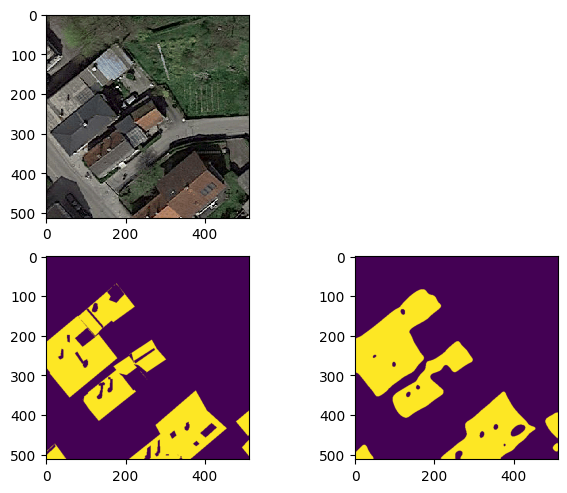

In [61]:
# Visualise the models' performance out-of-sample

i = 107

plt.subplot(2, 2, 1)
imshow(X_val[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_val_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(FCN_deep_1_preds_val[i]))

In [56]:
Model_performance = IoU(Y_val_seg, FCN_deep_1_preds_val)
Model_performance

0.8274435189621494

### FCN_deep 2

In [36]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

FCN_deep_2_preds_test = FCN_deep_2.predict(X_test, verbose=1)
FCN_deep_2_preds_test = (FCN_deep_2_preds_test > 0.35).astype(np.uint8)

6/6 [==============================] - 51s 6s/step


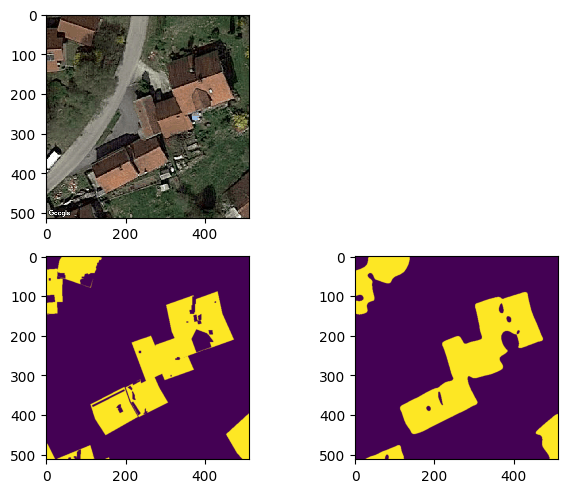

In [37]:
# Visualise the models' performance out-of-sample

i = 23

plt.subplot(2, 2, 1)
imshow(X_test[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_test_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(FCN_deep_2_preds_test[i]))

In [38]:
Model_performance = IoU(Y_test_seg, FCN_deep_2_preds_test)
Model_performance

0.8228034053313426

### FCN_deep 3

In [55]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

FCN_deep_3_preds_val = FCN_deep_3.predict(X_val, verbose=1)
FCN_deep_3_preds_val = (FCN_deep_3_preds_val > 0.45).astype(np.uint8)

6/6 [==============================] - 14s 3s/step


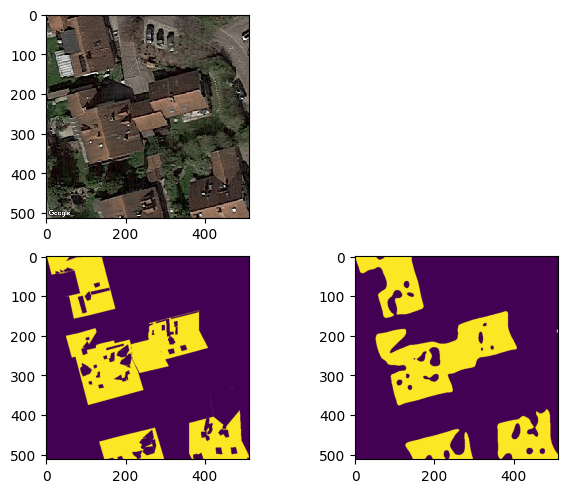

In [57]:
# Visualise the models' performance out-of-sample

i = 67

plt.subplot(2, 2, 1)
imshow(X_val[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_val_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(FCN_deep_3_preds_val[i]))

In [56]:
Model_performance = IoU(Y_val_seg, FCN_deep_3_preds_val)
Model_performance

0.8515734433977395

### FCN_deep 4

In [59]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

FCN_deep_4_preds_test = FCN_deep_4.predict(X_test, verbose=1)
FCN_deep_4_preds_test = (FCN_deep_4_preds_test > 0.45).astype(np.uint8)

6/6 [==============================] - 15s 3s/step


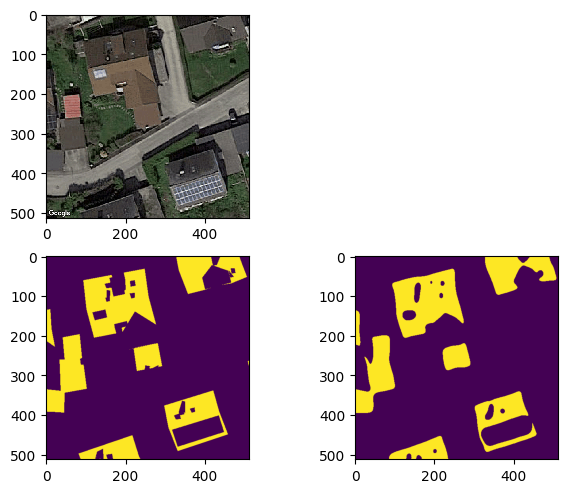

In [64]:
# Visualise the models performance out-of-sample

i = 21

plt.subplot(2, 2, 1)
imshow(X_test[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_test_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(FCN_deep_4_preds_test[i]))

In [61]:
Model_performance = IoU(Y_test_seg, FCN_deep_4_preds_test)
Model_performance

0.8667606859314084

## SegNet model

In [32]:
import cv2
import imageio
from PIL import Image
import numpy as np
from keras import backend as K
from keras.layers import Layer
from keras.layers import Input
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import img_to_array
from keras.models import Model
import argparse
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [33]:
class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, pool_size[0], pool_size[1], 1]
        padding = padding.upper()
        strides = [1, strides[0], strides[1], 1]
        output, argmax = tf.nn.max_pool_with_argmax(
            inputs,
            ksize=ksize,
            strides=strides,
            padding=padding)

        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')

            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3])

            ret = tf.scatter_nd(K.expand_dims(K.flatten(mask)),
                                  K.flatten(updates),
                                  [K.prod(output_shape)])

            input_shape = updates.shape
            out_shape = [-1,
                         input_shape[1] * self.size[0],
                         input_shape[2] * self.size[1],
                         input_shape[3]]
        return K.reshape(ret, out_shape)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [ ]:
def segnet(input_shape, n_labels, kernel=3, pool_size=(2, 2)):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (3,3), padding="same")(inputs)
    conv_1 = tf.keras.layers.BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (3,3), padding="same")(conv_1)
    #conv_2 = tf.keras.layers.BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (3,3), padding="same")(pool_1)
    #conv_3 = tf.keras.layers.BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (3,3)), padding="same")(conv_3)
    #conv_4 = tf.keras.layers.BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (3,3), padding="same")(pool_2)
    #conv_5 = tf.keras.layers.BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (3,3), padding="same")(conv_5)
    #conv_6 = tf.keras.layers.BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)


    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_6)

    conv_8 = Convolution2D(512, (3,3), padding="same")(pool_3)
    #conv_8 = tf.keras.layers.BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    
    
    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_8)

    conv_11 = Convolution2D(512, (3,3), padding="same")(pool_4)
   # conv_11 = tf.keras.layers.BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
   

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_11)
    print("Build enceder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (3,3), padding="same")(unpool_1)
    #conv_14 = tf.keras.layers.BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    

    unpool_2 = MaxUnpooling2D(pool_size)([conv_14, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    #conv_17 = tf.keras.layers.BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_17)
    #conv_19 = tf.keras.layers.BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    #conv_20 = tf.keras.layers.BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(128, (kernel, kernel), padding="same")(conv_20)
    #conv_21 = tf.keras.layers.BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
   
    unpool_4 = MaxUnpooling2D(pool_size)([conv_21, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    #conv_23 = tf.keras.layers.BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    #conv_24 = tf.keras.layers.BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    #conv_25 = tf.keras.layers.BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = tf.keras.layers.BatchNormalization()(conv_26)
    conv_26 = Reshape(
        (input_shape[0] * input_shape[1], n_labels),
        input_shape=(input_shape[0], input_shape[1], n_labels),
    )(conv_26)
    outputs = Activation('sigmoid')(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model


Segnet_model = segnet((512,512,3), n_labels=1 ,kernel=3, pool_size=(2,2))

Build enceder done..
Build decoder done..


In [44]:
Segnet_model.summary()

Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_68 (Conv2D)             (None, 512, 512, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 activation_68 (Activation)     (None, 512, 512, 64  0           ['conv2d_68[0][0]']              
                                )                                                            

## Evaluate the SegNet model performance

### SegNet Model 1

Model trained without the validation set and data augmentation. 

In [52]:
Tar_preds_val = target.predict(X_val, verbose=1)
#Tar_preds_val = (Tar_preds_val > 0.3).astype(np.uint8)

NameError: name 'target' is not defined

In [40]:
Tar_preds_val[23]

array([[[0.21492884],
        [0.21492884],
        [0.21492884],
        ...,
        [0.21492884],
        [0.21492884],
        [0.21492884]],

       [[0.21492884],
        [0.21492884],
        [0.21492884],
        ...,
        [0.21492884],
        [0.21492884],
        [0.21492884]],

       [[0.21492884],
        [0.21492884],
        [0.21492884],
        ...,
        [0.21492884],
        [0.21492884],
        [0.21492884]],

       ...,

       [[0.21492884],
        [0.21492884],
        [0.21492884],
        ...,
        [0.21492884],
        [0.21492884],
        [0.21492884]],

       [[0.21492884],
        [0.21492884],
        [0.21492884],
        ...,
        [0.21492884],
        [0.21492884],
        [0.21492884]],

       [[0.21492884],
        [0.21492884],
        [0.21492884],
        ...,
        [0.21492884],
        [0.21492884],
        [0.21492884]]], dtype=float32)

In [58]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

SegNet_1_preds_val = SegNet_1.predict(X_val, verbose=1)
SegNet_1_preds_val = (SegNet_1_preds_val > 0.3).astype(np.uint8)

6/6 [==============================] - 3s 381ms/step


<function matplotlib.pyplot.imshow(X: 'ArrayLike | PIL.Image.Image', cmap: 'str | Colormap | None' = None, norm: 'str | Normalize | None' = None, *, aspect: "Literal['equal', 'auto'] | float | None" = None, interpolation: 'str | None' = None, alpha: 'float | ArrayLike | None' = None, vmin: 'float | None' = None, vmax: 'float | None' = None, colorizer: 'Colorizer | None' = None, origin: "Literal['upper', 'lower'] | None" = None, extent: 'tuple[float, float, float, float] | None' = None, interpolation_stage: "Literal['data', 'rgba', 'auto'] | None" = None, filternorm: 'bool' = True, filterrad: 'float' = 4.0, resample: 'bool | None' = None, url: 'str | None' = None, data=None, **kwargs) -> 'AxesImage'>

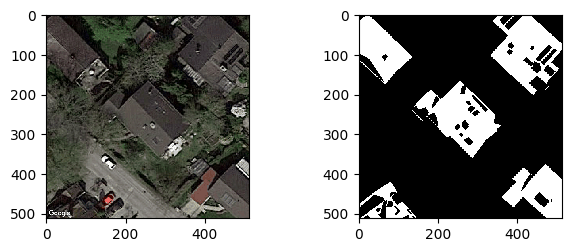

In [112]:
plt.subplot(2, 2, 1)
imshow(X_train[9])
plt.imshow

plt.subplot(2, 2, 2)
imshow(Y_train_seg[9])
plt.imshow

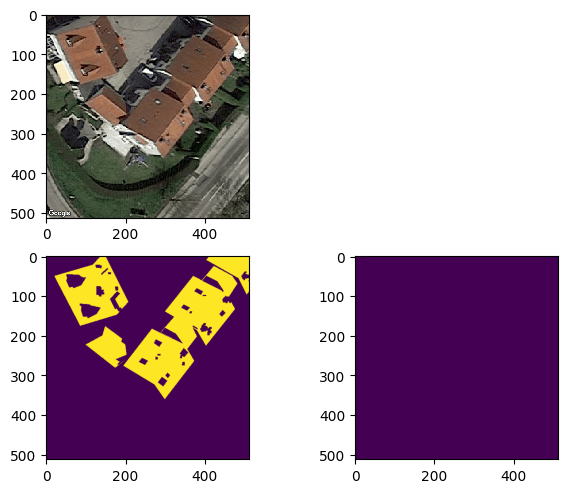

In [66]:
# Visualise the models performance on out-of-sample data

i = 25

plt.subplot(2, 2, 1)
imshow(X_val[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_val_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(SegNet_1_preds_val[i]))

In [60]:
Model_performance = IoU(Y_val_seg, SegNet_1_preds_val)
Model_performance

0.030245111743441907

### SegNet Model 2

Model trained with validation set but no data augmentation.

In [ ]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

SegNet_2_preds_test = SegNet_2.predict(X_test, verbose=1)
SegNet_2_preds_test = (SegNet_2_preds_test > 0.55).astype(np.uint8)

In [ ]:
# Visualise the models performance on out-of-sample data

i = 23

plt.subplot(2, 2, 1)
imshow(X_test[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_test_seg[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(FCN_deep_2_preds_test[i]))

In [ ]:
Model_performance = IoU(Y_test_seg, FCN_deep_2_preds_test)
Model_performance

### SegNet Model 3

Model trained with validation set but no data augmentation.

In [ ]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

SegNet_3_preds_val = SegNet_3.predict(X_val_aug, verbose=1)
SegNet_3_preds_val = (SegNet_3_preds_val > 0.30).astype(np.uint8)

In [ ]:
# Visualise the model  performance on out-of-sample data

i = 45

plt.subplot(2, 2, 1)
imshow(X_val_aug[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_val_seg_aug[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(SegNet_3_preds_val[i]))

In [ ]:
Model_performance = IoU(Y_val_seg_aug, SegNet_3_preds_val)
Model_performance

### SegNet Model 4

Model trained with validation set and data augmentation.

In [ ]:
# Model gives predictions between 0 and 1
# A threshold is need to map these values to 0 or 1
# This threshold can be adjusted

SegNet_4_preds_test = SegNet_4.predict(X_test_aug, verbose=1)
SegNet_4_preds_test = (SegNet_4_preds_test > 0.5).astype(np.uint8)

In [ ]:
# Visualise the model performance on out-of-sample data

i = 23*2-10

plt.subplot(2, 2, 1)
imshow(X_test_aug[i])
plt.imshow

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(Y_test_seg_aug[i]))

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(SegNet_4_preds_test[i]))

In [ ]:
Model_performance = IoU(Y_test_seg_aug, SegNet_4_preds_test)
Model_performance

## PV potential

In [ ]:
def area(2d_image, image_width, image_height, meters_per_pixel):
    roof_area = np.array(2d_image).sum()
    roof_area = roof_area * meters_per_pixel**2 # This gives the area in meteres squared
    
    